# Load PTQ Experiments

In [1]:
import incense
from common.helper.config import parseMongoConfig

loader = incense.ExperimentLoader(
    **parseMongoConfig('../config.ini', adapt='IncenseExperimentLoader'))
all_ptq_experiments_query = {
    '$and': [{
        'experiment.name': 'PTQ_CNN-IMU'
    }, {
        'status': 'COMPLETED'
    }, {
        '_id': {
            '$gte': 792
        }
    }]
}
all_experiments = loader.find(all_ptq_experiments_query)
print(f'Loaded {len(all_experiments)} PTQ Experiments')

base_experiment_by_dataset = {}
for ex in all_experiments:
  cfg = ex.to_dict()['config']
  if cfg['use_dataset'] in base_experiment_by_dataset:
    assert base_experiment_by_dataset[cfg['use_dataset']] == cfg['trained_model_run_id']
  else:
    base_experiment_by_dataset[cfg['use_dataset']] = cfg['trained_model_run_id']
base_experiment_by_dataset = {
    d: loader.find_by_id(e_id) for d, e_id in base_experiment_by_dataset.items()
}
print(f'Base Experiments {base_experiment_by_dataset}')

friendly = {
  'lara': 'LARa',
  'opportunity': 'Opportunity-Locomotion',
  'pamap2': 'Pamap2',
}

Loaded 774 PTQ Experiments
Base Experiments {'opportunity': Experiment(id=787, name=CNN-IMU_Opportunity-Locomotion), 'pamap2': Experiment(id=788, name=CNN-IMU_Pamap2(activity_labels)), 'lara': Experiment(id=786, name=CNN-IMU_LARa)}


# Compare observer configirations for 7 bit precision

Select the Top $k$ models by their $wF_1$ score on the test set. Plot their corresponding 
median times for analyzing a calibration batch of size 128.

Number of observer variance experiments = 54
\begin{tabular}{rlll}
\hline
   Top # & Opportunity-Locomotion                                              & Pamap2                                                              & LARa                                                                \\
\hline
       1 & {A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: halb\\G: Kanal}         & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: voll\\G: Tensor}  & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Tensor} \\
       2 & {A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Kanal}        & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\B: voll\\G: Tensor}     & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\B: symm.\\G: Tensor}    \\
       3 & {A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Tensor}       & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\B: symm.\\G: Kanal}     & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Kanal}  \\
       4 & {A: \textsc{MinMax}\

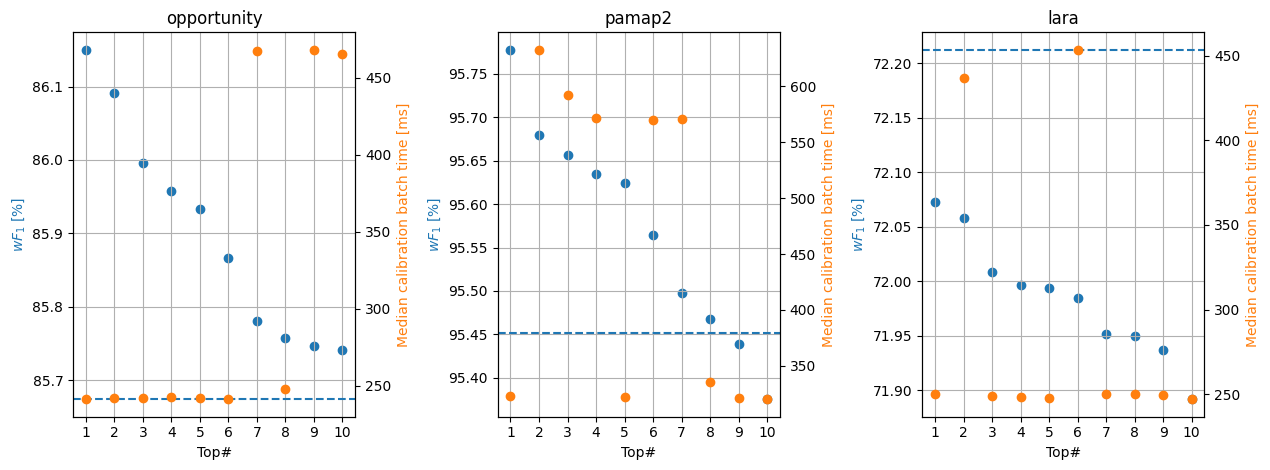

In [2]:
import matplotlib.pyplot as plt
from common.eval.experiments import metricTopK, configSubset
from tabulate import tabulate
from collections import defaultdict
import numpy as np
from matplotlib import cm

observer_vairance_experiments = list(
    filter(lambda e: e.to_dict()['meta']['my_meta']['runner'] == 'ptq_cnn_imu_run_observer.py',
           all_experiments))
print(f'Number of observer variance experiments = {len(observer_vairance_experiments)}')

observer_var_by_dataset = defaultdict(list)
for ex in observer_vairance_experiments:
  observer_var_by_dataset[ex.to_dict()['config']['use_dataset']].append(ex)

config_subset = [
    'activation_observer',
    'weight_observer',
    'weight_range',
]


def cell(e) -> str:
  friendly_range = {
    'full' : 'voll',
    'symmetric' : 'symm.',
    'uint' : 'halb',
  }
  friendly_observer = {
    'MovingAverageMinMaxObserver' : '\\textsc{MovingMinMax}',
    'PerChannelMinMaxObserver' : '\\textsc{MinMax}',
    'MinMaxObserver' : '\\textsc{MinMax}',
    'HistogramObserver' : '\\textsc{Histogram}',
  }
  friendly_gran = {
    'PerChannelMinMaxObserver' : 'Kanal',
    'MinMaxObserver' : 'Tensor',
  }
  activation = e.to_dict()['config']['activation_observer'].split('.')[-1]
  weight = e.to_dict()['config']['weight_observer'].split('.')[-1]
  weightrange = e.to_dict()['config']['weight_range']
  return f'{{A: {friendly_observer[activation]}\\\\P: {friendly_observer[weight]}\\\\B: {friendly_range[weightrange]}\\\\G: {friendly_gran[weight]}}}'

def point_wf1(ex) -> float:
  return ex.metrics['test/wf1'].max()


def point_time(ex) -> float:
  return ex.metrics['calibration/batch_time'].median()


top_k = 10
top_k_by_dataset = {
    k: metricTopK(exs, 'test/wf1', top_k) for k, exs in observer_var_by_dataset.items()
}
cmap = cm.get_cmap('tab10')

fig, axs = plt.subplots(1, len(top_k_by_dataset))
fig.set_figwidth(fig.get_figwidth() * 2)
for ix, (dataset, experiments) in enumerate(top_k_by_dataset.items()):
  top_wf1 = np.array(list(map(point_wf1, experiments)))
  top_tme = np.array(list(map(point_time, experiments)))
  top_ixs = np.arange(start=1, stop=top_wf1.shape[0] + 1)
  axs[ix].scatter(x=top_ixs, y=top_wf1 * 100, color=cmap(0), label='$wF_1$')
  tx = axs[ix].twinx()
  tx.scatter(x=top_ixs, y=top_tme * 1000, color=cmap(1), label='batch_time')
  axs[ix].set_title(dataset)
  axs[ix].set_ylabel('$wF_1$ [%]', color=cmap(0))
  tx.set_ylabel('Median calibration batch time [ms]', color=cmap(1))
  axs[ix].set_xlabel('Top#')
  axs[ix].grid()
  axs[ix].set_xticks(top_ixs)
  axs[ix].axhline(y=point_wf1(base_experiment_by_dataset[dataset]) * 100, linestyle='dashed')
fig.tight_layout()
fig.show()

table_header = ['Top #'] + list(map(lambda n: friendly[n], top_k_by_dataset.keys()))
table_data = zip(range(1, top_k + 1),
                 *[[cell(e) for e in exs] for _, exs in top_k_by_dataset.items()])
print(tabulate(tabular_data=table_data, headers=table_header, tablefmt='latex_raw'))

Now sort all models by the median calibration batch-time and make boxplots of all calibration batch-times.  Also scatter their $wF_1$ scores on the test set.

Top #,opportunity,pamap2,lara
1,{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: halb\\G: Kanal},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: halb\\G: Tensor},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: halb\\G: Tensor}
2,{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: voll\\G: Tensor},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: voll\\G: Tensor},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Kanal}
3,{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Kanal},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Kanal},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: voll\\G: Kanal}
4,{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: voll\\G: Kanal},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Tensor},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Tensor}
5,{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Tensor},{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: halb\\G: Kanal},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: halb\\G: Kanal}
6,{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: halb\\G: Tensor},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: voll\\G: Kanal},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: voll\\G: Tensor}
7,{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: voll\\G: Kanal},{A: \textsc{MinMax}\\P: \textsc{MinMax}\\B: halb\\G: Kanal},{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Kanal}
8,{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Tensor},{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: halb\\G: Tensor},{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: halb\\G: Kanal}
9,{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Kanal},{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: voll\\G: Kanal},{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: voll\\G: Tensor}
10,{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: halb\\G: Kanal},{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: voll\\G: Tensor},{A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\B: symm.\\G: Tensor}


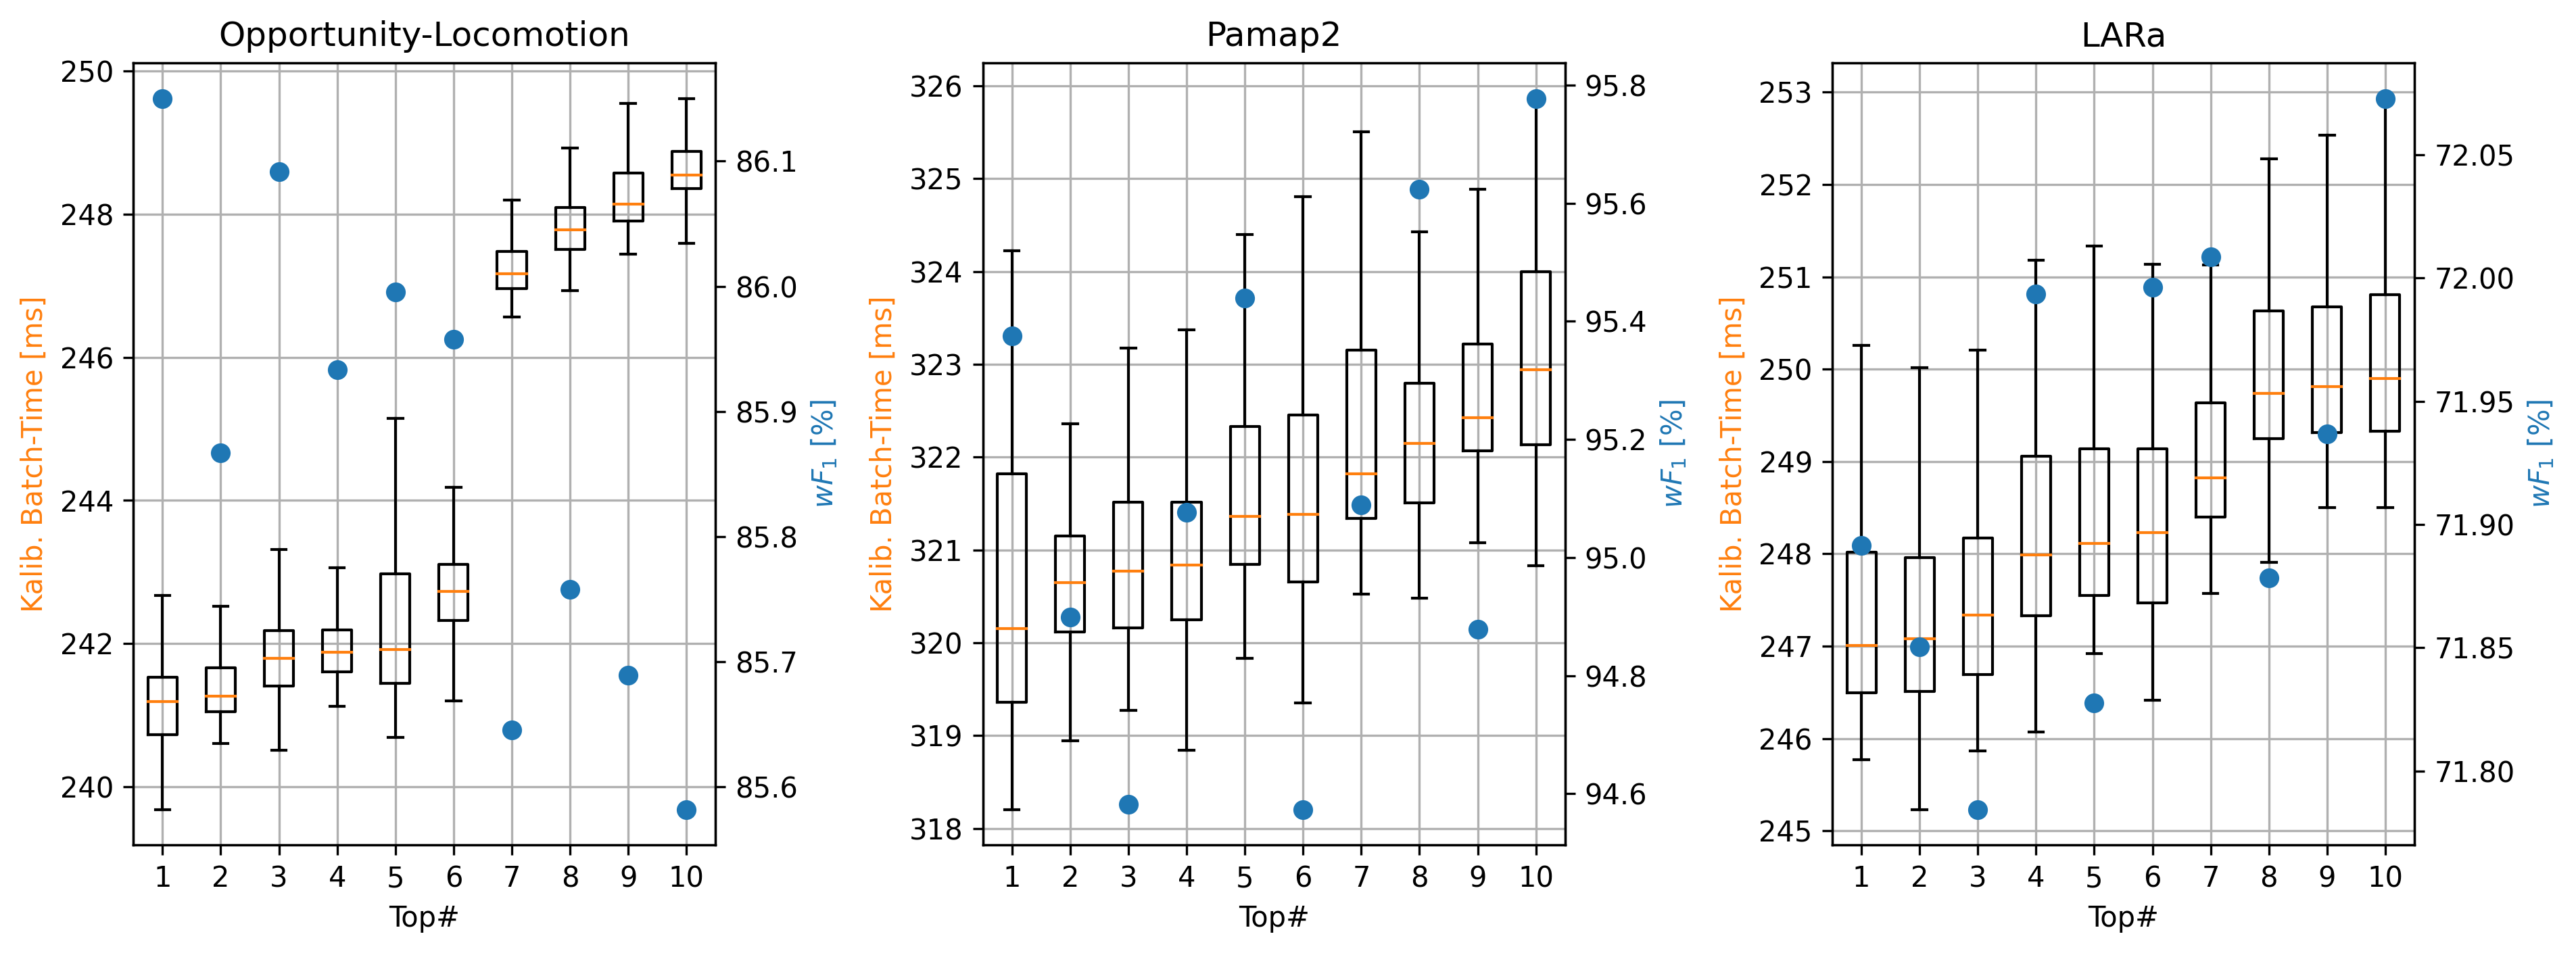

In [3]:
import matplotlib.pyplot as plt
from common.eval.experiments import metricTopK
from tabulate import tabulate
from collections import defaultdict
import numpy as np
from matplotlib import cm

def point_wf1(ex) -> float:
  return ex.metrics['test/wf1'].max()


def times(ex) -> float:
  return ex.metrics['calibration/batch_time']


top_k = 10
top_k_by_dataset = {
    k: metricTopK(exs, 'calibration/batch_time', top_k, mode='min', fold='median') for k, exs in observer_var_by_dataset.items()
}
cmap = cm.get_cmap('tab10')

fig, axs = plt.subplots(1, len(top_k_by_dataset))
fig.set_dpi(300)
fig.set_figwidth(fig.get_figwidth() * 2)
for ix, (dataset, experiments) in enumerate(top_k_by_dataset.items()):
  top_wf1 = np.array(list(map(point_wf1, experiments)))
  top_ixs = np.arange(start=1, stop=top_wf1.shape[0] + 1)
  axs[ix].boxplot(x=[times(e)*1000 for e in experiments], showfliers=False)
  tx = axs[ix].twinx()
  tx.scatter(x=top_ixs, y=top_wf1 * 100, color=cmap(0), label='$wF_1$ [%]')
  axs[ix].set_title(friendly[dataset])
  axs[ix].set_ylabel('Kalib. Batch-Time [ms]', color=cmap(1))
  tx.set_ylabel('$wF_1$ [%]', color=cmap(0))
  axs[ix].set_xlabel('Top#')
  axs[ix].grid()
  axs[ix].set_xticks(top_ixs)
fig.tight_layout()
fig.show()

table_header = ['Top #'] + list(top_k_by_dataset.keys())
table_data = zip(range(1, top_k + 1),
                 *[[cell(e) for e in exs] for _, exs in top_k_by_dataset.items()])
tabulate(tabular_data=table_data, headers=table_header, tablefmt='html')

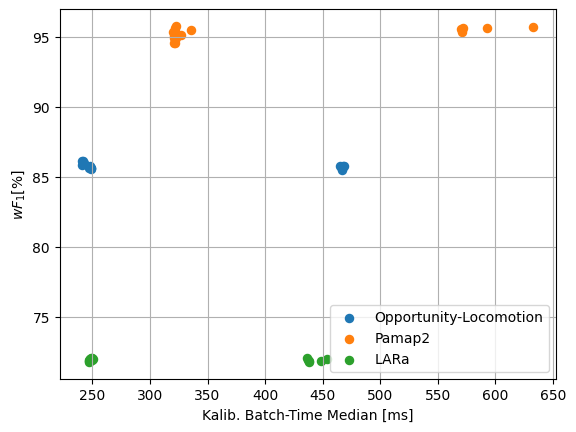

In [4]:
import matplotlib.pyplot as plt
from common.eval.experiments import metricTopK
from tabulate import tabulate
from collections import defaultdict
import numpy as np
from matplotlib import cm


def point_wf1(ex) -> float:
  return ex.metrics['test/wf1'].max()


def times(ex):
  return ex.metrics['calibration/batch_time']

def mtimes(ex) -> float:
  return times(ex).median()

def stimes(ex) -> float:
  return times(ex).std()

fig, ax = plt.subplots()
for dataset, experiments in observer_var_by_dataset.items():
  ts = np.array(list(map(mtimes, experiments))) * 1000
  wf1s = np.array(list(map(point_wf1, experiments))) * 100
  ax.scatter(x=ts, y=wf1s, s=34, label=friendly[dataset])
  ax.set_ylabel('$wF_1 [\\%]$')
  ax.set_xlabel('Kalib. Batch-Time Median [ms]')

ax.grid()
ax.legend()

# Impact of the MovingAverageObserver at 7 bit precision

For all configurations, calculate the absolute $wF_1$ score difference by choosing a `MovingAverageMinMaxObserver`
over an `MinMaxObserver`.

Index,opportunity,pamap2,lara
1,"('full', 'torch.ao.quantization.MinMaxObserver')","('full', 'torch.ao.quantization.MinMaxObserver')","('full', 'torch.ao.quantization.PerChannelMinMaxObserver')"
2,"('symmetric', 'torch.ao.quantization.MinMaxObserver')","('symmetric', 'torch.ao.quantization.PerChannelMinMaxObserver')","('symmetric', 'torch.ao.quantization.PerChannelMinMaxObserver')"
3,"('full', 'torch.ao.quantization.PerChannelMinMaxObserver')","('symmetric', 'torch.ao.quantization.MinMaxObserver')","('symmetric', 'torch.ao.quantization.MinMaxObserver')"
4,"('uint', 'torch.ao.quantization.MinMaxObserver')","('uint', 'torch.ao.quantization.PerChannelMinMaxObserver')","('uint', 'torch.ao.quantization.MinMaxObserver')"
5,"('symmetric', 'torch.ao.quantization.PerChannelMinMaxObserver')","('full', 'torch.ao.quantization.PerChannelMinMaxObserver')","('uint', 'torch.ao.quantization.PerChannelMinMaxObserver')"
6,"('uint', 'torch.ao.quantization.PerChannelMinMaxObserver')","('uint', 'torch.ao.quantization.MinMaxObserver')","('full', 'torch.ao.quantization.MinMaxObserver')"


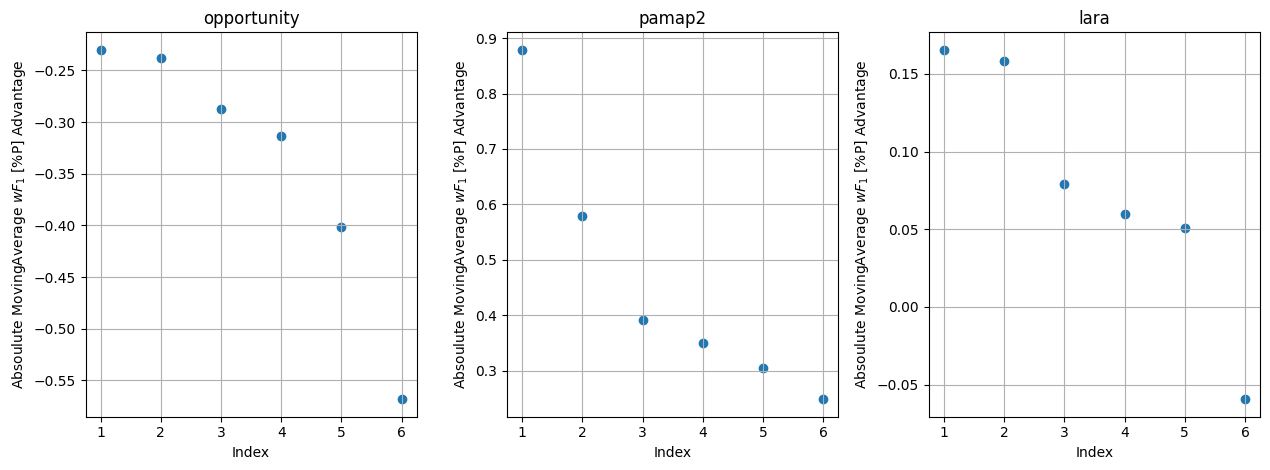

In [5]:
config_eq = {
    'activation_observer',
    'weight_observer',
    'weight_range',
}
config_diff = {
    'activation_observer': [
        'torch.ao.quantization.MinMaxObserver', 'torch.ao.quantization.MovingAverageMinMaxObserver'
    ]
}
config_eq = config_eq.difference(config_diff.keys())

ex_moving_minus_by_dataset = {}
for dataset, experiments in observer_var_by_dataset.items():
  ex_bins = defaultdict(lambda: defaultdict(list))
  for ex in experiments:
    subset_e = configSubset(ex, config_eq)
    subset_d = configSubset(ex, config_diff.keys())
    if all([v in config_diff[k] for k, v in subset_d.items()]):
      ex_bins[tuple(subset_e.values())][tuple(subset_d.values())].append(ex)

  ex_moving_minus_non_moving = {
      cfg: point_wf1(exs[config_diff['activation_observer'][1],][0]) -
      point_wf1(exs[config_diff['activation_observer'][0],][0]) for cfg, exs in ex_bins.items()
  }

  ex_moving_minus_by_dataset[dataset] = dict(sorted(ex_moving_minus_non_moving.items(), key=lambda x:x[1], reverse=True))



fig, axs = plt.subplots(1, len(ex_moving_minus_by_dataset))
fig.set_figwidth(fig.get_figwidth() * 2)
xs = []
for ix, (dataset, experiments) in enumerate(ex_moving_minus_by_dataset.items()):
  xs = np.array(range(1, len(experiments)+1))
  ys = np.array(list(experiments.values()))
  axs[ix].scatter(x=xs, y=ys*100)
  axs[ix].set_ylabel(f'Absoulute MovingAverage $wF_1$ [%P] Advantage')
  axs[ix].set_xlabel('Index')
  axs[ix].set_xticks(xs)
  axs[ix].set_title(dataset)
  axs[ix].grid()
fig.tight_layout()
fig.show()

table_header = ['Index'] + list(ex_moving_minus_by_dataset.keys())
table_data = zip(xs, *[[str(cfg) for cfg in exs] for exs in ex_moving_minus_by_dataset.values()])
tabulate(tabular_data=table_data, headers=table_header, tablefmt='html')


# Inference time gain

Since all statically quantized models technically have the same inference time, select the best model
for each dataset and compare the inference time to the baseline model.

[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matp

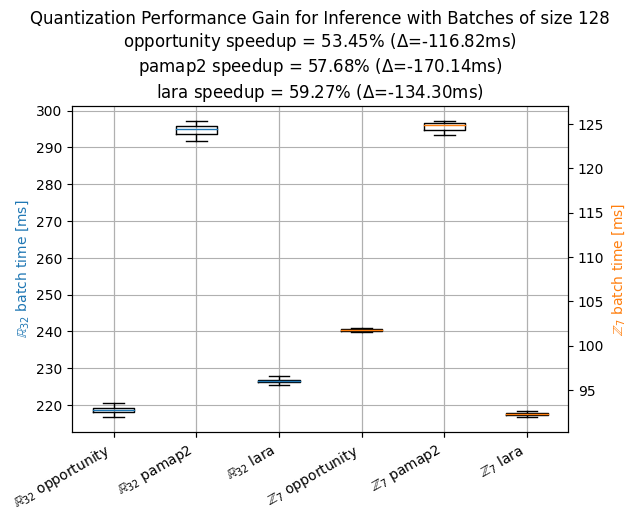

In [6]:
from common.eval.experiments import metricBest

ptq_rep_ex_by_dataset = {
  ds: metricBest(exs, metric='test/wf1', mode='max')
  for ds, exs in observer_var_by_dataset.items()
}


labels = []
xs_fp32 = []
xs_int8 = []
for dataset in base_experiment_by_dataset:
  labels.append(f'$\\mathbb{{R}}_{{32}}$ {dataset}')
  xs_fp32.append(base_experiment_by_dataset[dataset].metrics['test/batch_time']*1000)
  xs_int8.append([])
for dataset in ptq_rep_ex_by_dataset:
  labels.append(f'$\\mathbb{{Z}}_{{7}}$ {dataset}')
  xs_int8.append(ptq_rep_ex_by_dataset[dataset].metrics['test/batch_time']*1000)
  xs_fp32.append([])

before_after_median_by_dataset={
  dataset: (base_experiment_by_dataset[dataset].metrics['test/batch_time'].median(), ptq_rep_ex_by_dataset[dataset].metrics['test/batch_time'].median())
  for dataset in base_experiment_by_dataset
}

fig, ax = plt.subplots()
tx = ax.twinx()
ax.boxplot(x=xs_fp32, labels=labels, showfliers=False, medianprops={'color': cmap(0)})
tx.boxplot(x=xs_int8, labels=[""]*6, showfliers=False, medianprops={'color': cmap(1)})
ax.set_ylabel('$\\mathbb{R}_{32}$ batch time [ms]', color=cmap(0))
tx.set_ylabel('$\\mathbb{Z}_{7}$ batch time [ms]', color=cmap(1))
ax.grid()
title = f'Quantization Performance Gain for Inference with Batches of size 128'
for dataset, (before, after) in before_after_median_by_dataset.items():
  delta = after - before
  decrease = 100 * (1- (after/before))
  title += f'\n{dataset} speedup = {decrease:.02f}% ($\\Delta$={1000*delta:.02f}ms)'
ax.set_title(title)
fig.autofmt_xdate()
fig.show()

# Evaluate best configurations for each bit precision

Check how the observers impact the precision for lower bit-widths, then 7.

Number of bit variance experiments = 144
\begin{tabular}{rllll}
\hline
   #Bits & Top 1 (LARa)                                              & Top 2 (LARa)                                              & Top 3 (LARa)                                              & Top 4 (LARa)                                              \\
\hline
       7 & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Kanal}  & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Tensor}    & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Tensor} & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Kanal}     \\
       6 & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Tensor} & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Kanal}  & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Kanal}     & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Tensor}    \\
       5 & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Kanal}  & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Tensor} & {A: \textsc{Histogram}\\P: \textsc{

\begin{tabular}{rllll}
\hline
   #Bits & Top 1 (Opportunity-Locomotion)                            & Top 2 (Opportunity-Locomotion)                            & Top 3 (Opportunity-Locomotion)                         & Top 4 (Opportunity-Locomotion)                            \\
\hline
       7 & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Kanal}  & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Tensor}    & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Kanal}  & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Tensor} \\
       6 & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Tensor} & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Kanal}  & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Tensor} & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Kanal}     \\
       5 & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Tensor} & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Kanal}  & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Kanal}  & {A: \textsc{Histogram}\\P: \

\begin{tabular}{rllll}
\hline
   #Bits & Top 1 (Pamap2)                                            & Top 2 (Pamap2)                                            & Top 3 (Pamap2)                                            & Top 4 (Pamap2)                                            \\
\hline
       7 & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Tensor}    & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Tensor} & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Kanal}     & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Kanal}  \\
       6 & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Kanal}     & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Tensor}    & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Tensor} & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Kanal}  \\
       5 & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Kanal}     & {A: \textsc{Histogram}\\P: \textsc{MinMax}\\G: Tensor}    & {A: \textsc{MovingMinMax}\\P: \textsc{MinMax}\\G: Tensor} & {A: \textsc{Movi

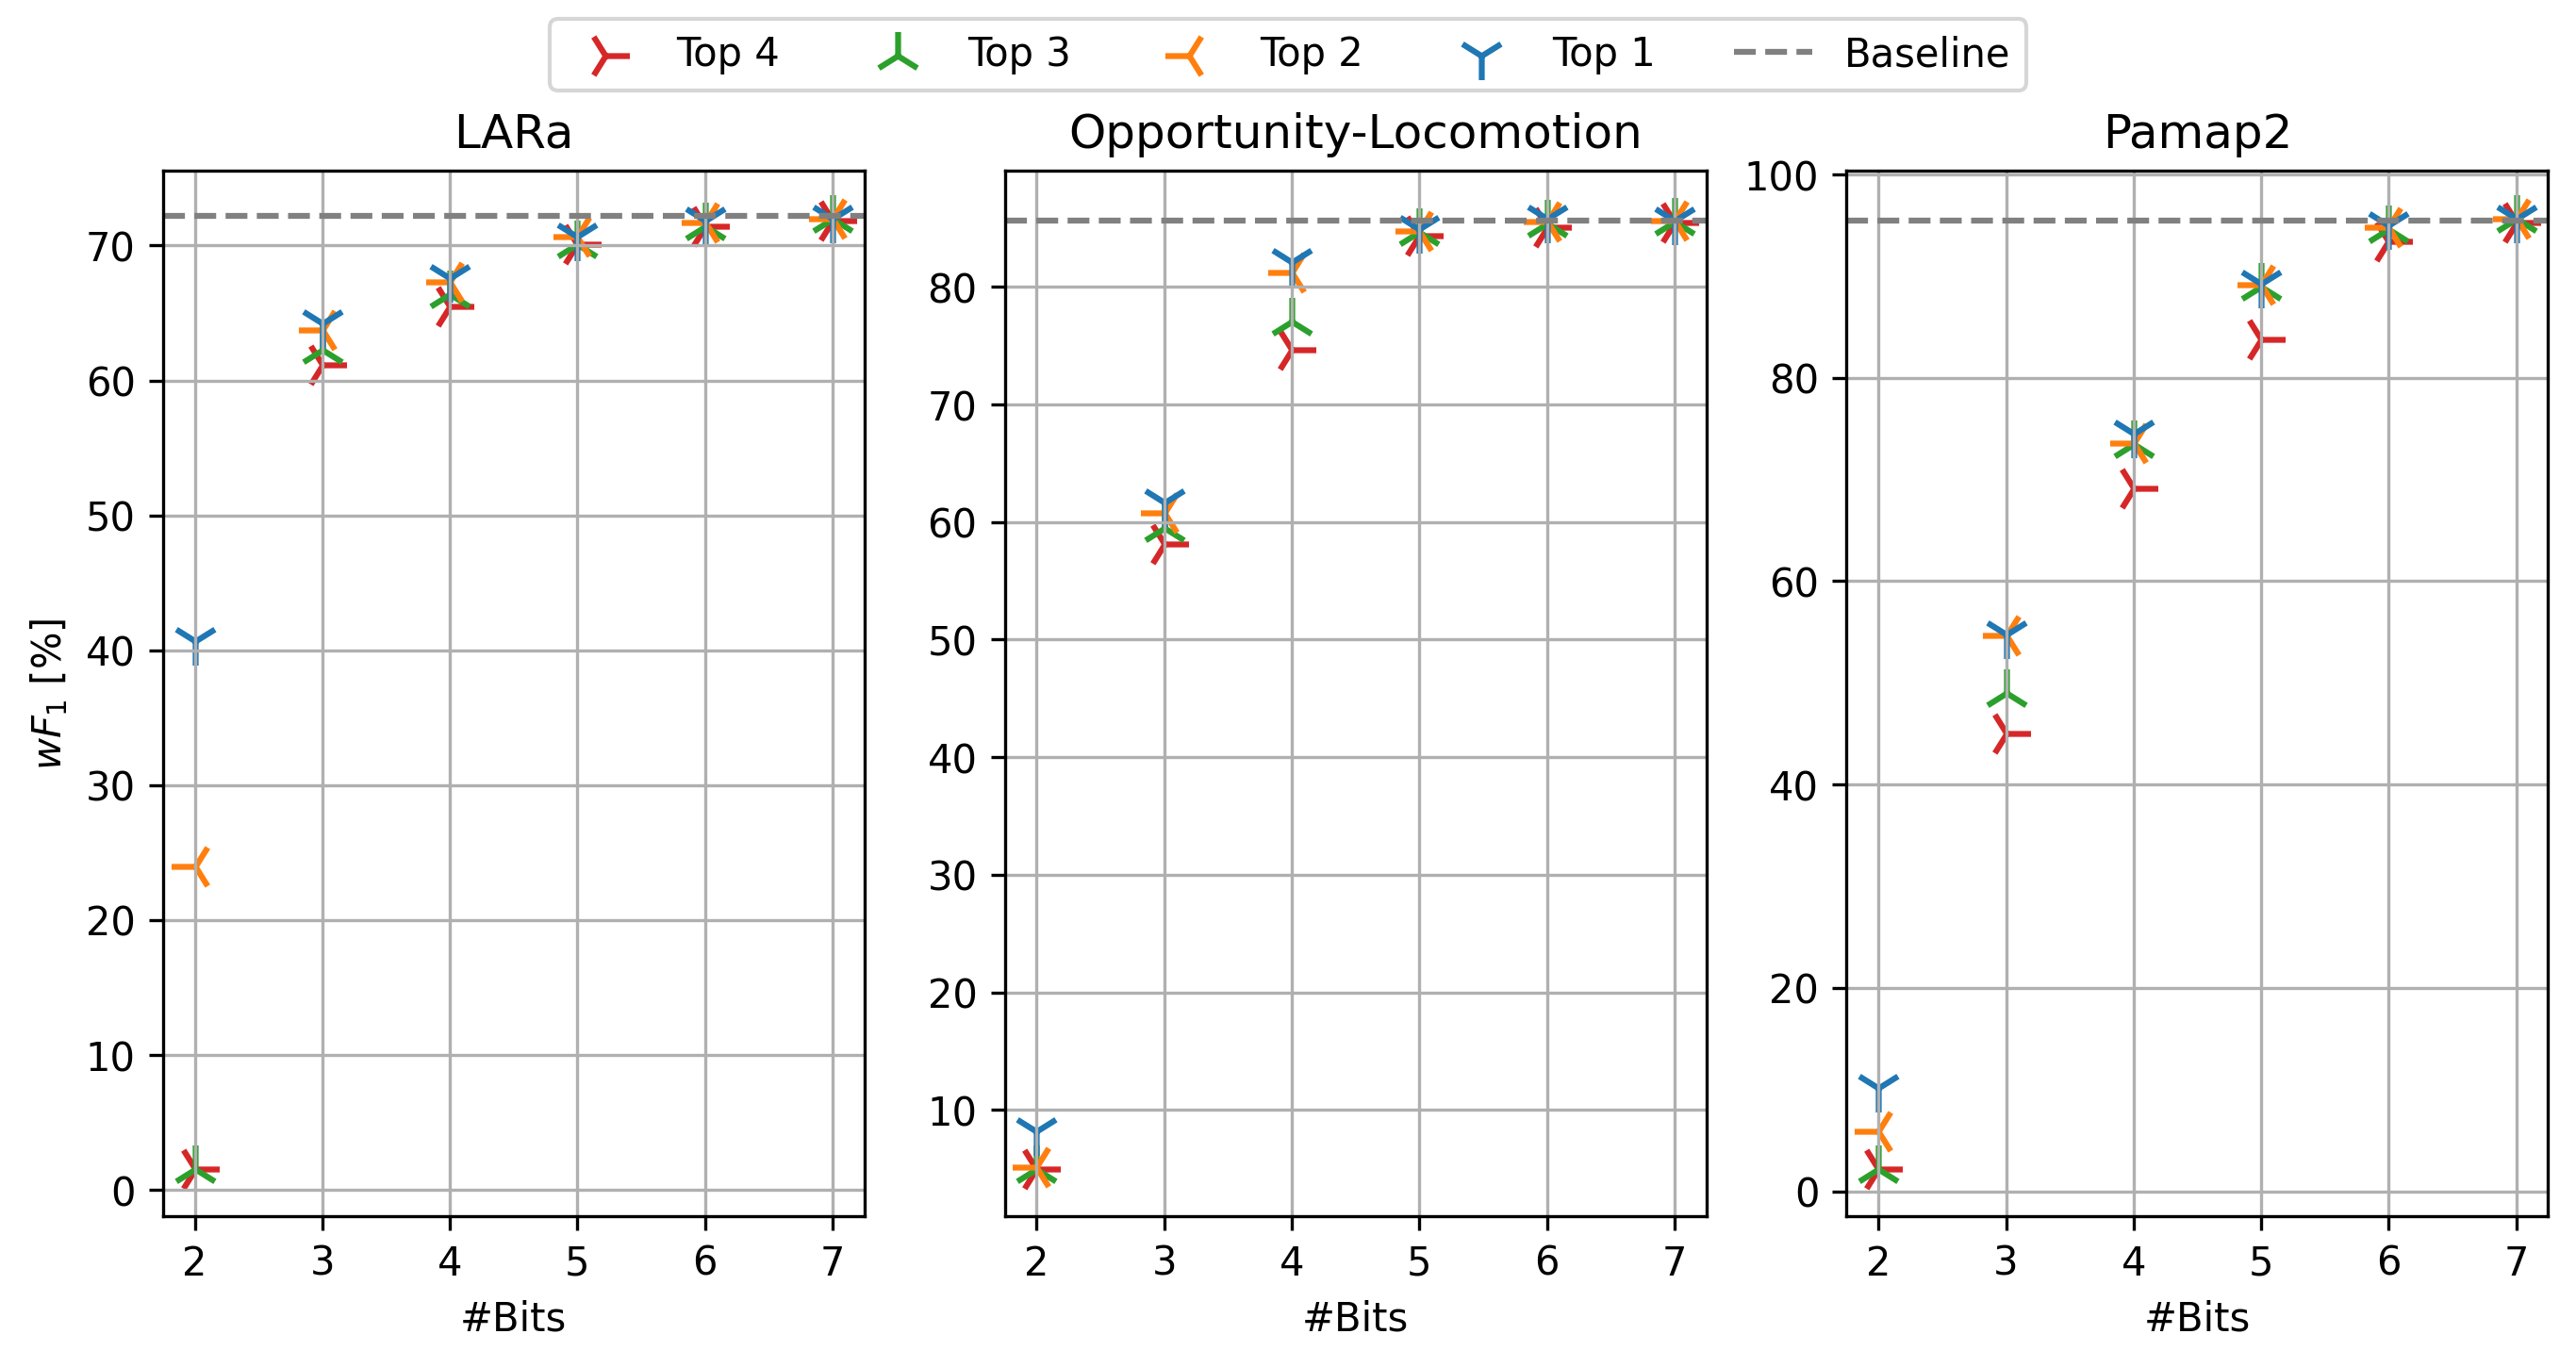

In [7]:
from IPython.display import HTML, display

bit_vairance_experiments = list(
    filter(lambda e: e.to_dict()['meta']['my_meta']['runner'] == 'ptq_cnn_imu_run_bit_depth.py',
           all_experiments))
print(f'Number of bit variance experiments = {len(bit_vairance_experiments)}')

ex_by_bits_by_dataset = defaultdict(lambda: defaultdict(list))
for ex in bit_vairance_experiments:
  cfg = configSubset(ex, keys=['use_dataset', 'n_bits'])
  if ex.to_dict()['config']['imu_input_quantization'] == 'static':
    ex_by_bits_by_dataset[cfg['use_dataset']][cfg['n_bits']].append(ex)

top_k = 4

top_k_by_bits_by_dataset = {
    dataset: {
        bits: metricTopK(exs, metric='test/wf1', k=top_k, mode='max')
        for bits, exs in sorted(ex_by_bits.items(), key=lambda x:x[0], reverse=True)
    } for dataset, ex_by_bits in ex_by_bits_by_dataset.items()
}

ex_by_bits_by_top_ix_by_dataset = defaultdict(lambda: defaultdict(dict))
for dataset, top_k_by_bits in top_k_by_bits_by_dataset.items():
  for bits, tk in top_k_by_bits.items():
    for ix, ex in enumerate(tk):
      ex_by_bits_by_top_ix_by_dataset[dataset][ix+1][bits] = ex

markers = [
  '1', '3', '2', '4',
]

fig, axs = plt.subplots(1, len(ex_by_bits_by_dataset))
fig.set_dpi(300)
fig.set_figwidth(fig.get_figwidth() * 1.7)
handles, labels = [], []
for ix, dataset in enumerate(ex_by_bits_by_top_ix_by_dataset):
  xs = []
  for tk_ix, ex_by_bits in list(ex_by_bits_by_top_ix_by_dataset[dataset].items())[::-1]:
    xs = np.array(list(ex_by_bits.keys()))
    ys = np.array(list(map(lambda e: e.metrics['test/wf1'], ex_by_bits.values())))*100
    axs[ix].scatter(x=xs, y=ys, color=cmap(tk_ix-1), label=f'Top {tk_ix}', marker=markers[tk_ix-1], s=150)

  baseline = base_experiment_by_dataset[dataset].metrics['test/wf1'].max() * 100
  axs[ix].set_xticks(xs)
  axs[ix].axhline(y=baseline, linestyle='dashed', label='Baseline', color='grey')
  if ix == 0:
    axs[ix].set_ylabel('$wF_1$ [%]')
  axs[ix].set_xlabel('#Bits')
  axs[ix].set_title(friendly[dataset])
  axs[ix].grid()
  handles, labels = axs[ix].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', ncol=top_k+1)
fig.show()

def cell(e) -> str:
  friendly_range = {
    'full' : 'voll',
    'symmetric' : 'symm.',
    'unit' : 'halb',
  }
  friendly_observer = {
    'MovingAverageMinMaxObserver' : '\\textsc{MovingMinMax}',
    'PerChannelMinMaxObserver' : '\\textsc{MinMax}',
    'MinMaxObserver' : '\\textsc{MinMax}',
    'HistogramObserver' : '\\textsc{Histogram}',
  }
  friendly_gran = {
    'PerChannelMinMaxObserver' : 'Kanal',
    'MinMaxObserver' : 'Tensor',
  }
  activation = e.to_dict()['config']['activation_observer'].split('.')[-1]
  weight = e.to_dict()['config']['weight_observer'].split('.')[-1]
  weightrange = e.to_dict()['config']['weight_range']
  return f'{{A: {friendly_observer[activation]}\\\\P: {friendly_observer[weight]}\\\\G: {friendly_gran[weight]}}}'


for dataset, ex_by_bits_by_top_ix in ex_by_bits_by_top_ix_by_dataset.items():
  table_header = ['#Bits'] + [f'Top {ix} ({friendly[dataset]})' for ix in ex_by_bits_by_top_ix]
  bits = ex_by_bits_by_top_ix[1].keys()
  table_data = zip(bits, *[[cell(e) for e in ex_by_bits.values()] for ex_by_bits in ex_by_bits_by_top_ix.values()])
  print(tabulate(tabular_data=table_data, headers=table_header, tablefmt='latex_raw'))
  display(HTML(tabulate(tabular_data=table_data, headers=table_header, tablefmt='html')))

# Impact of mixed Quantization
Run a broad comparison of selective quantization for:
- Input Block
- Covolution Pipeline
- Pipeline FC
- Classifier FC
- Output Layer

Number of mode variance experiments (subset) = 288


#Bits,Top 1 (lara),Top 2 (lara),Top 3 (lara),Top 4 (lara)
7,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none'
6,input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='static' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'
5,input_q='static' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'
4,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none'
3,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none'
2,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'


#Bits,Top 1 (opportunity),Top 2 (opportunity),Top 3 (opportunity),Top 4 (opportunity)
7,input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='static' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none'
6,input_q='static' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='static'
5,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none'
4,input_q='static' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'
3,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none'
2,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none'


#Bits,Top 1 (pamap2),Top 2 (pamap2),Top 3 (pamap2),Top 4 (pamap2)
7,input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='static',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='static',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='static'
6,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none'
5,input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'
4,input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='static'
3,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'
2,input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='static'


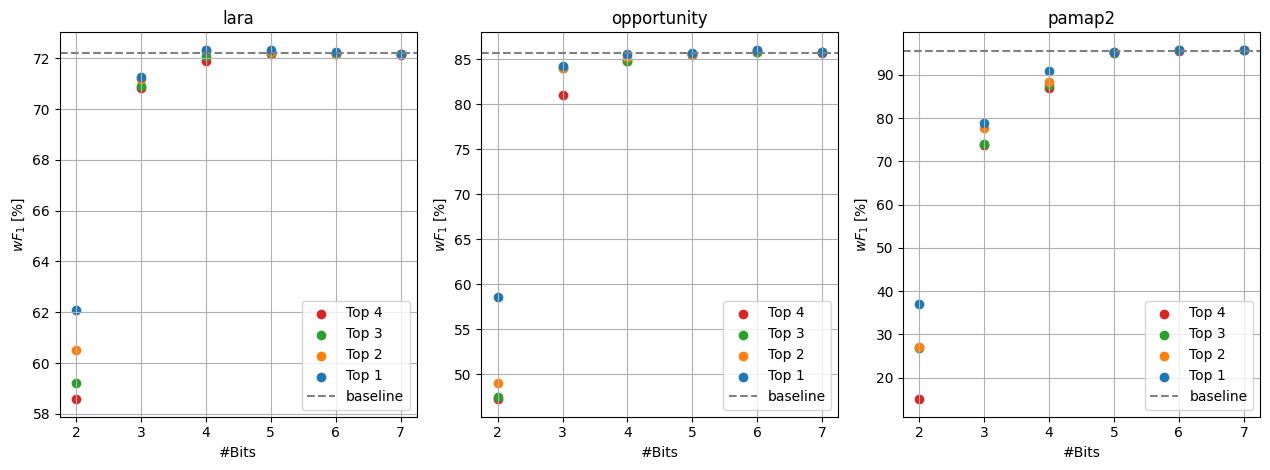

In [8]:
def predicate_mode(e) -> bool:
  return e.to_dict()['meta']['my_meta']['runner'] == 'ptq_cnn_imu_run_bit_depth_modes.py'

def predicate_subset(e) -> bool:
  cfg = e.to_dict()['config']

  pipe = cfg['imu_pipeline_quantization'] == 'static'
  pipe_fc = cfg['imu_pipeline_fc_quantization'] == 'static'
  fc = cfg['fc_quantization'] == 'static'

  return any((
      pipe and pipe_fc and not fc,
      not pipe and pipe_fc and fc,
      not pipe and not pipe_fc and fc,
      pipe and pipe_fc and fc,
  ))


mode_vairance_experiments = list(filter(predicate_mode, all_experiments))
mode_vairance_experiments_subset = list(filter(predicate_subset, mode_vairance_experiments))
print(f'Number of mode variance experiments (subset) = {len(mode_vairance_experiments_subset)}')

ex_by_bits_by_dataset = defaultdict(lambda: defaultdict(list))
for ex in mode_vairance_experiments_subset:
  cfg = configSubset(ex, keys=['use_dataset', 'n_bits'])
  ex_by_bits_by_dataset[cfg['use_dataset']][cfg['n_bits']].append(ex)

top_k = 4

top_k_by_bits_by_dataset = {
    dataset: {
        bits: metricTopK(exs, metric='test/wf1', k=top_k, mode='max')
        for bits, exs in sorted(ex_by_bits.items(), key=lambda x: x[0], reverse=True)
    } for dataset, ex_by_bits in ex_by_bits_by_dataset.items()
}

ex_by_bits_by_top_ix_by_dataset = defaultdict(lambda: defaultdict(dict))
for dataset, top_k_by_bits in top_k_by_bits_by_dataset.items():
  for bits, tk in top_k_by_bits.items():
    for ix, ex in enumerate(tk):
      ex_by_bits_by_top_ix_by_dataset[dataset][ix + 1][bits] = ex

fig, axs = plt.subplots(1, len(ex_by_bits_by_dataset))
fig.set_figwidth(fig.get_figwidth() * 2)
for ix, dataset in enumerate(ex_by_bits_by_top_ix_by_dataset):
  for tk_ix, ex_by_bits in list(ex_by_bits_by_top_ix_by_dataset[dataset].items())[::-1]:
    xs = np.array(list(ex_by_bits.keys()))
    ys = np.array(list(map(lambda e: e.metrics['test/wf1'], ex_by_bits.values()))) * 100
    axs[ix].scatter(x=xs, y=ys, color=cmap(tk_ix - 1), label=f'Top {tk_ix}')

  baseline = base_experiment_by_dataset[dataset].metrics['test/wf1'].max() * 100
  axs[ix].axhline(y=baseline, linestyle='dashed', label='baseline', color='grey')
  axs[ix].set_ylabel('$wF_1$ [%]')
  axs[ix].set_xlabel('#Bits')
  axs[ix].set_title(dataset)
  axs[ix].legend()
  axs[ix].grid()

fig.tight_layout()
fig.show()


def cell(e) -> str:
  input_q = e.to_dict()['config']['imu_input_quantization']
  pipe_q = e.to_dict()['config']['imu_pipeline_quantization']
  pipe_fc_q = e.to_dict()['config']['imu_pipeline_fc_quantization']
  fc_q = e.to_dict()['config']['fc_quantization']
  out_q = e.to_dict()['config']['output_layer_quantization']
  return f'{input_q=} \n{pipe_q=} \n{pipe_fc_q=} \n{fc_q=} \n{out_q=}'


for dataset, ex_by_bits_by_top_ix in ex_by_bits_by_top_ix_by_dataset.items():
  table_header = ['#Bits'] + [f'Top {ix} ({dataset})' for ix in ex_by_bits_by_top_ix]
  bits = ex_by_bits_by_top_ix[1].keys()
  table_data = zip(
      bits,
      *[[cell(e) for e in ex_by_bits.values()] for ex_by_bits in ex_by_bits_by_top_ix.values()])
  display(HTML(tabulate(tabular_data=table_data, headers=table_header, tablefmt='html')))

# Time/$wF_1$ tadeoff for selected experiments

[INF][torch.distributed.nn.jit.instantiator] Created a temporary directory at /tmp/tmp2o4p45si
[INF][torch.distributed.nn.jit.instantiator] Writing /tmp/tmp2o4p45si/_remote_module_non_scriptable.py


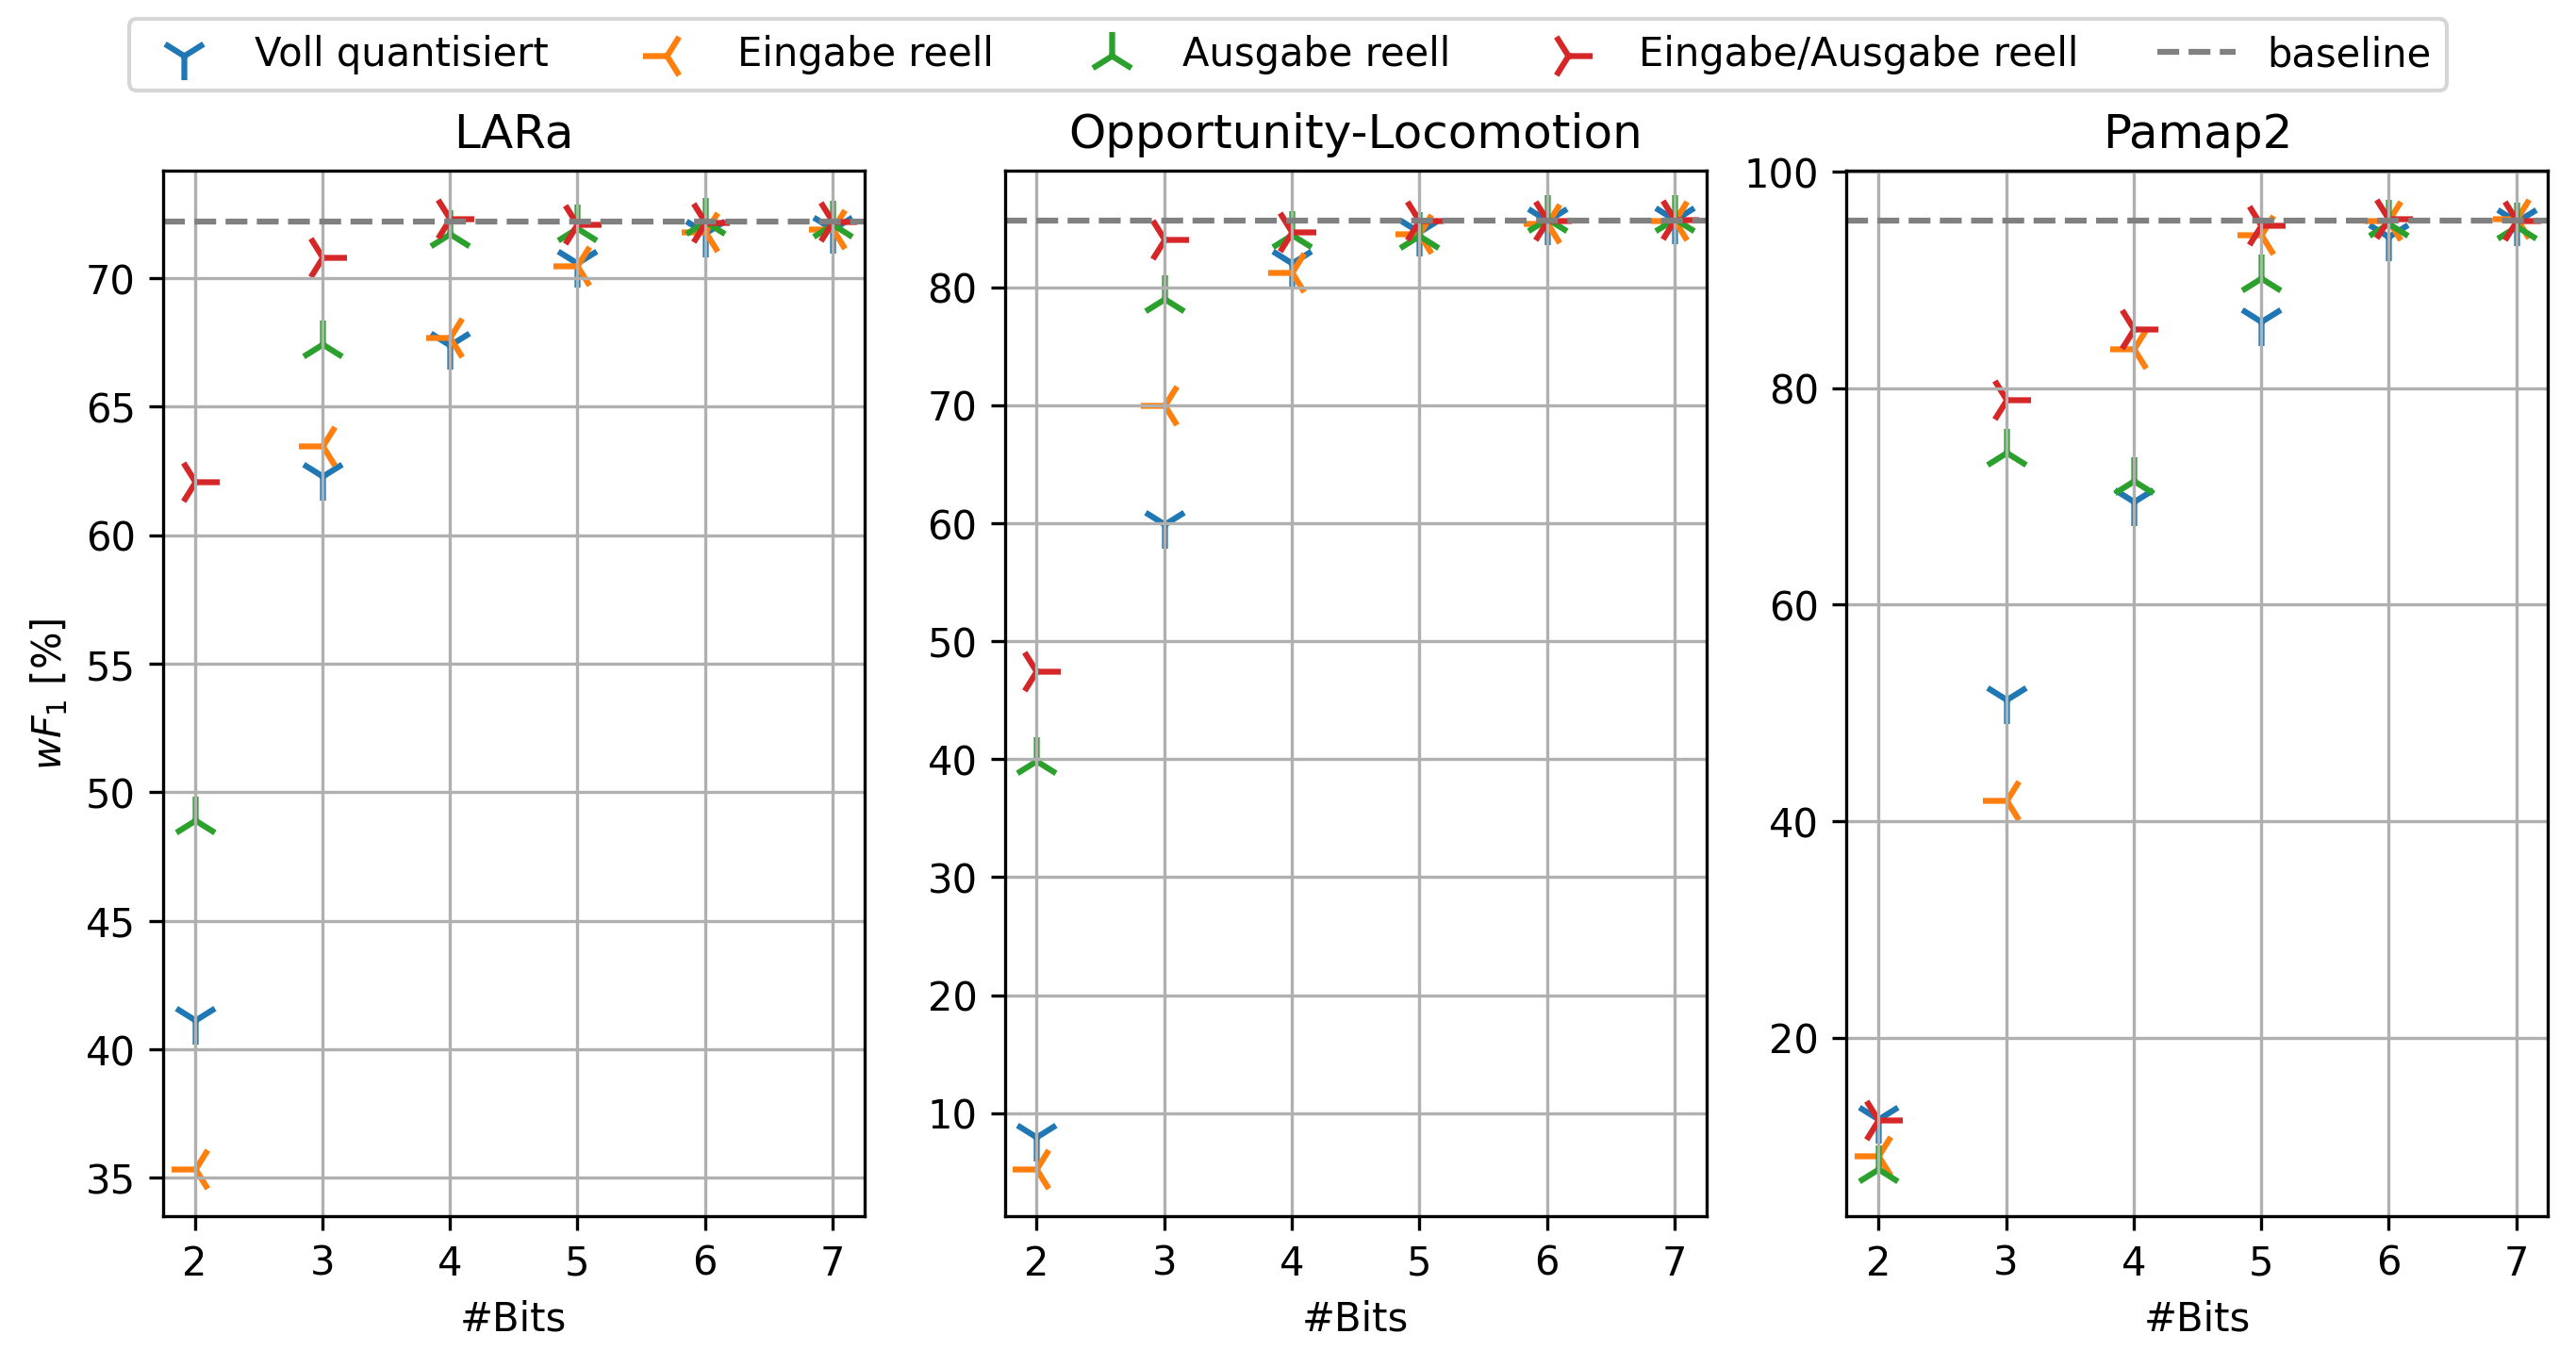

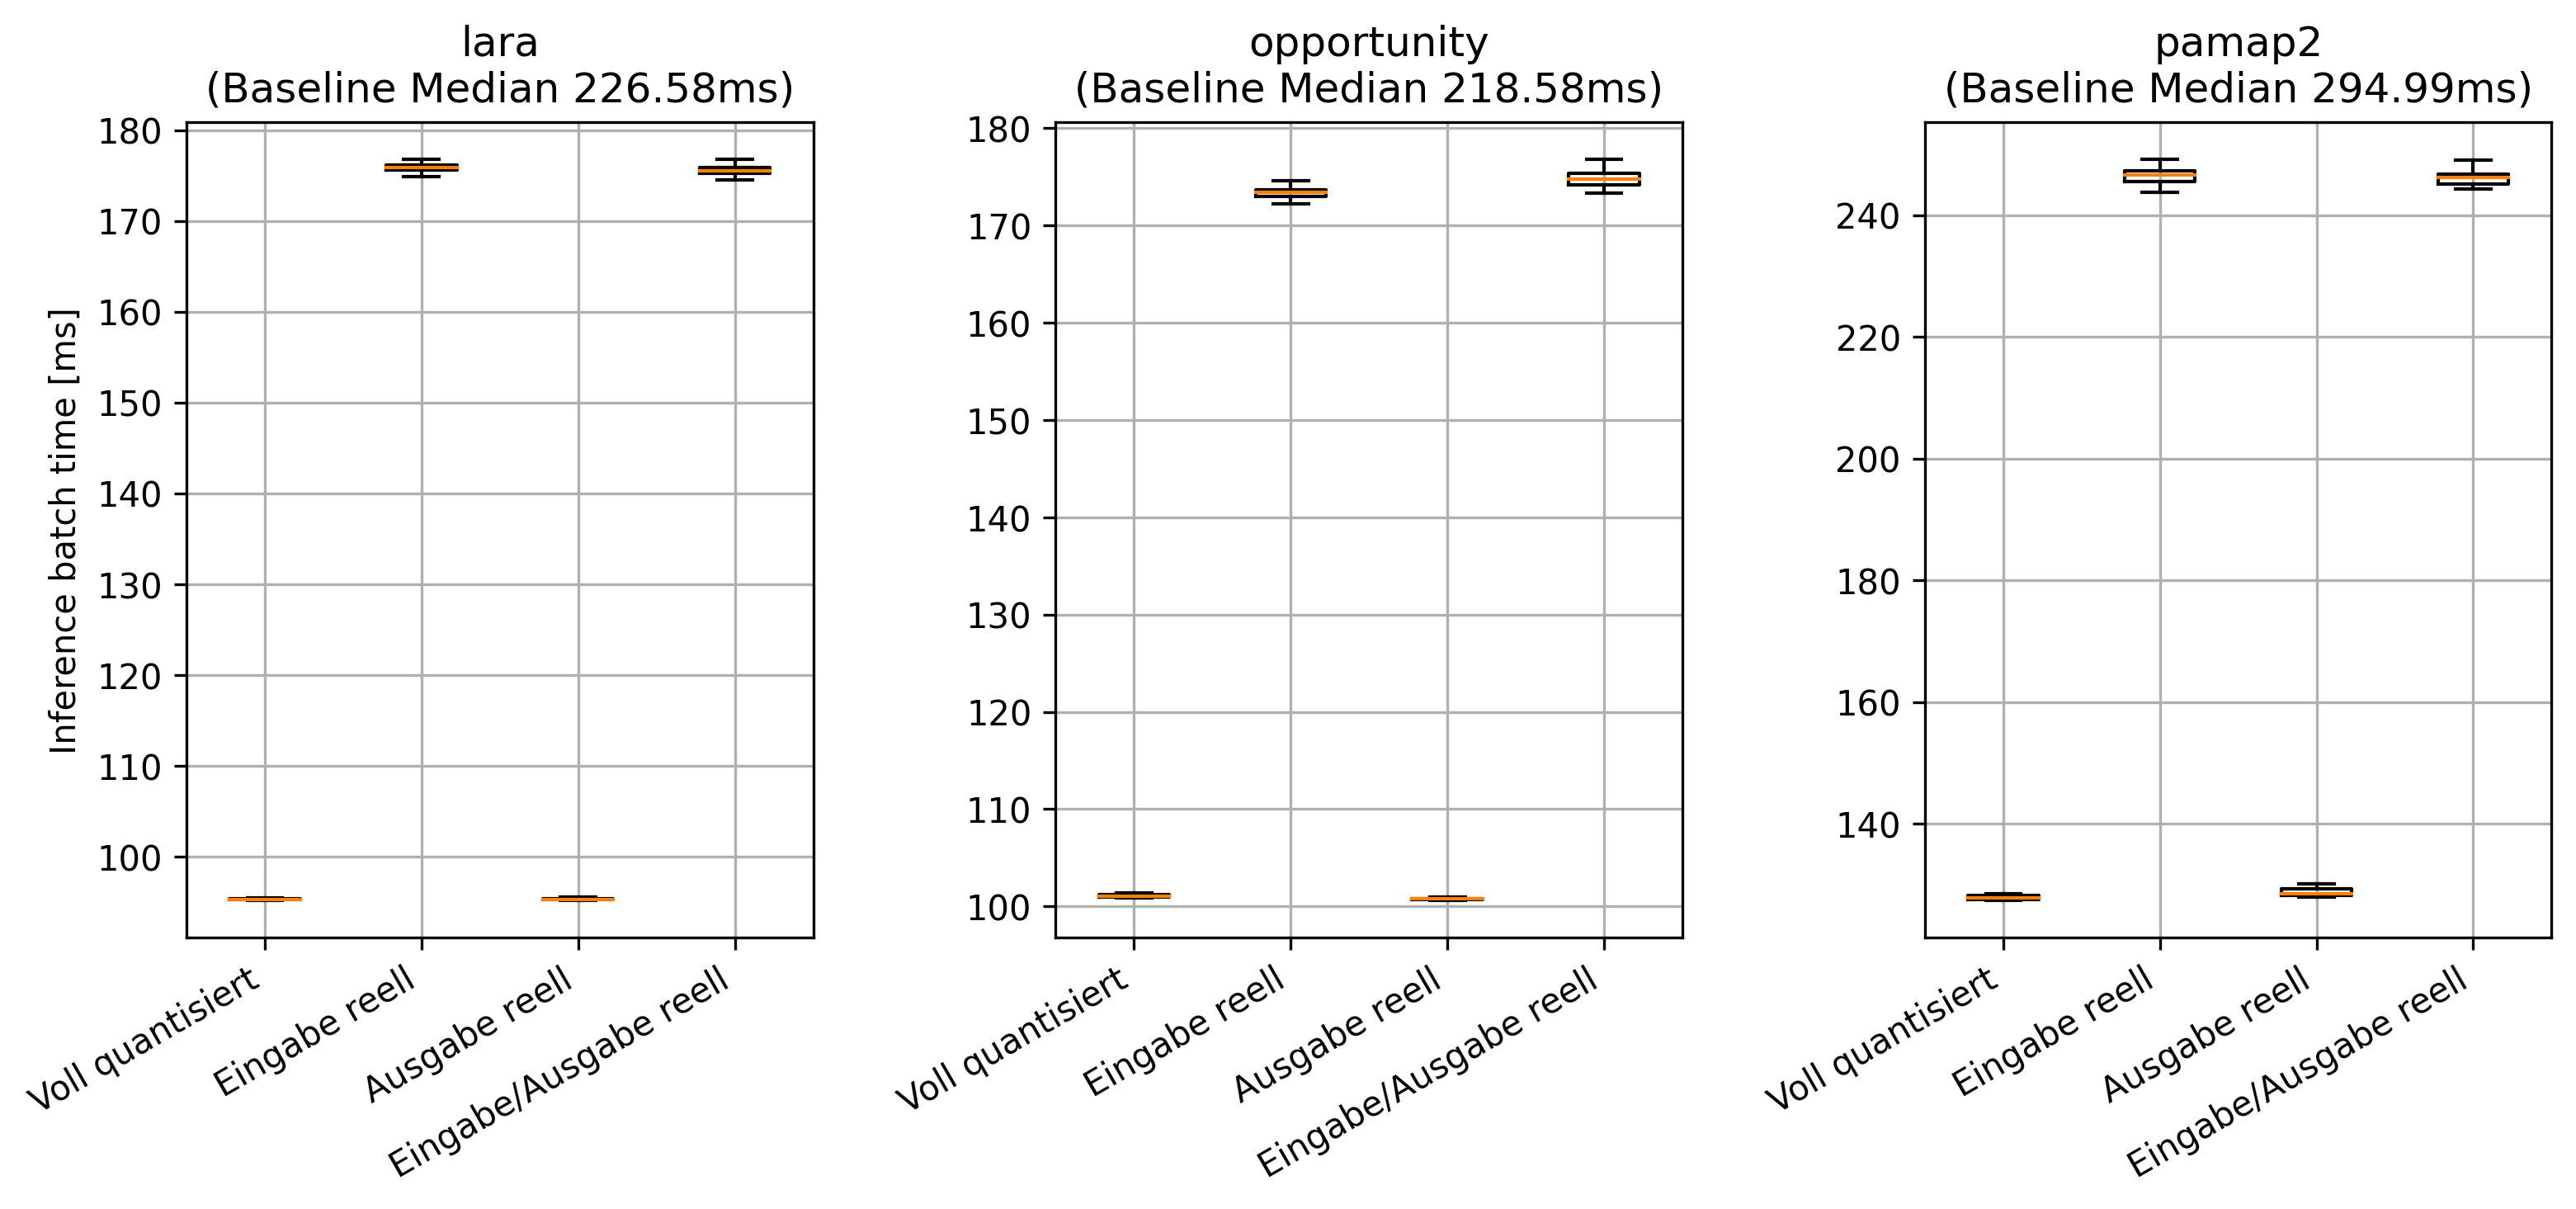

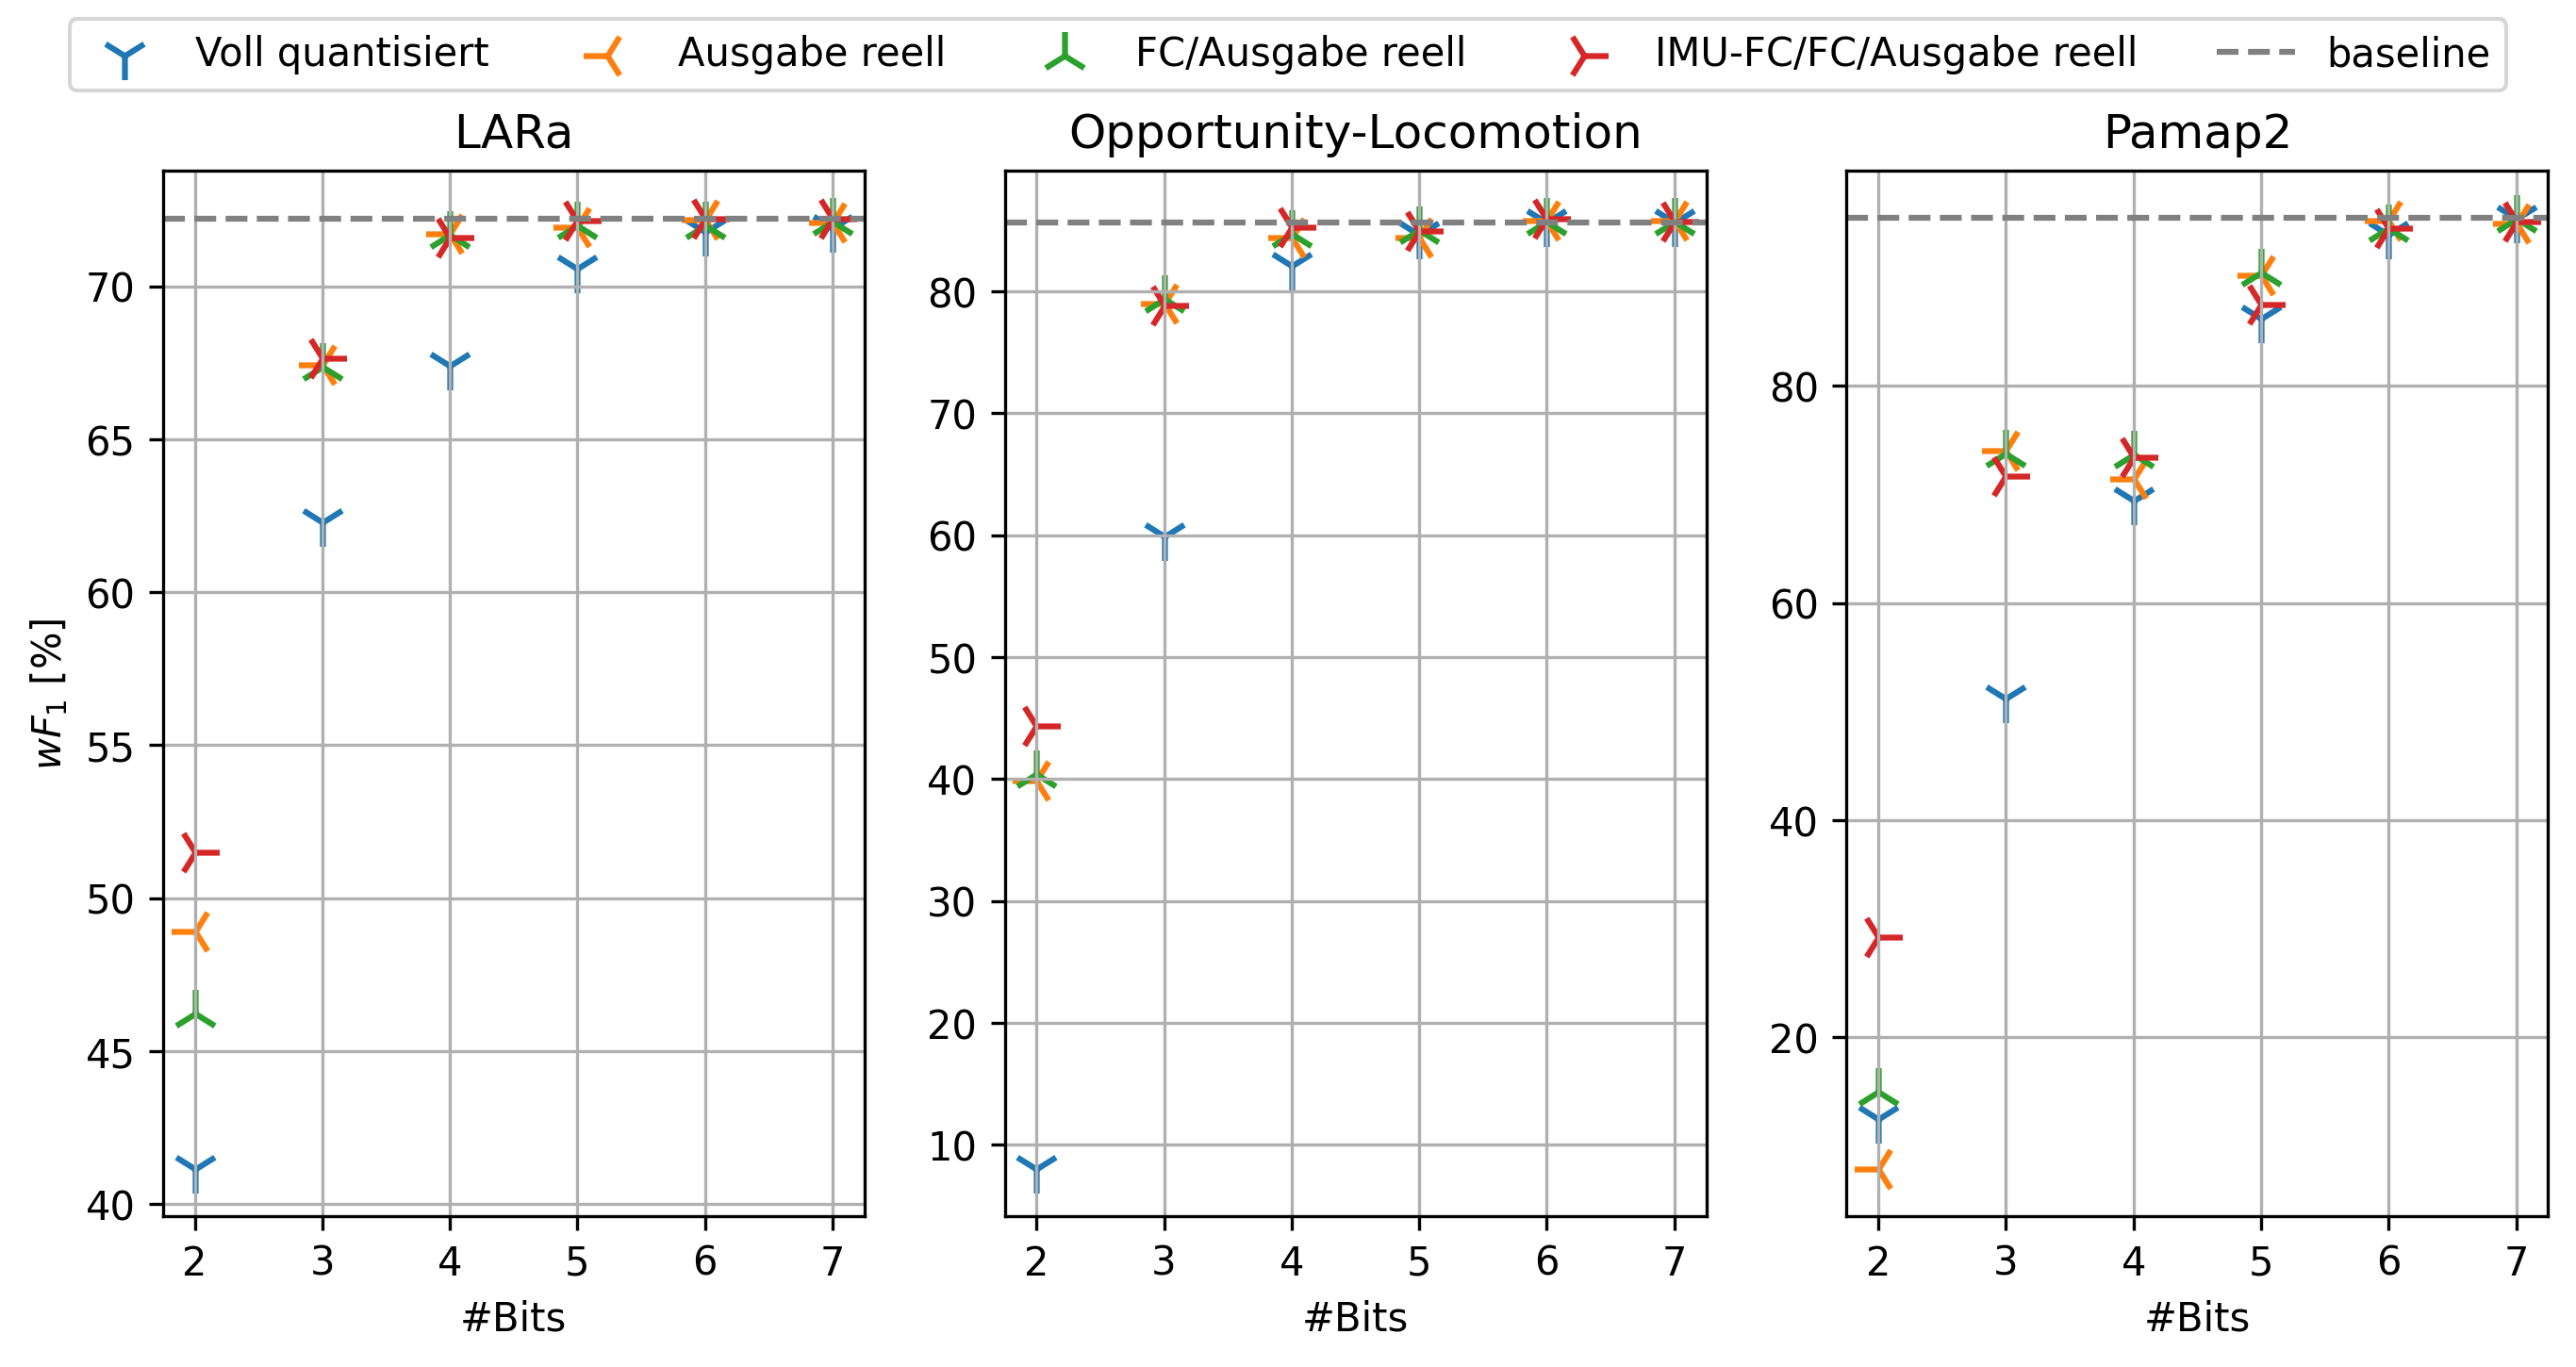

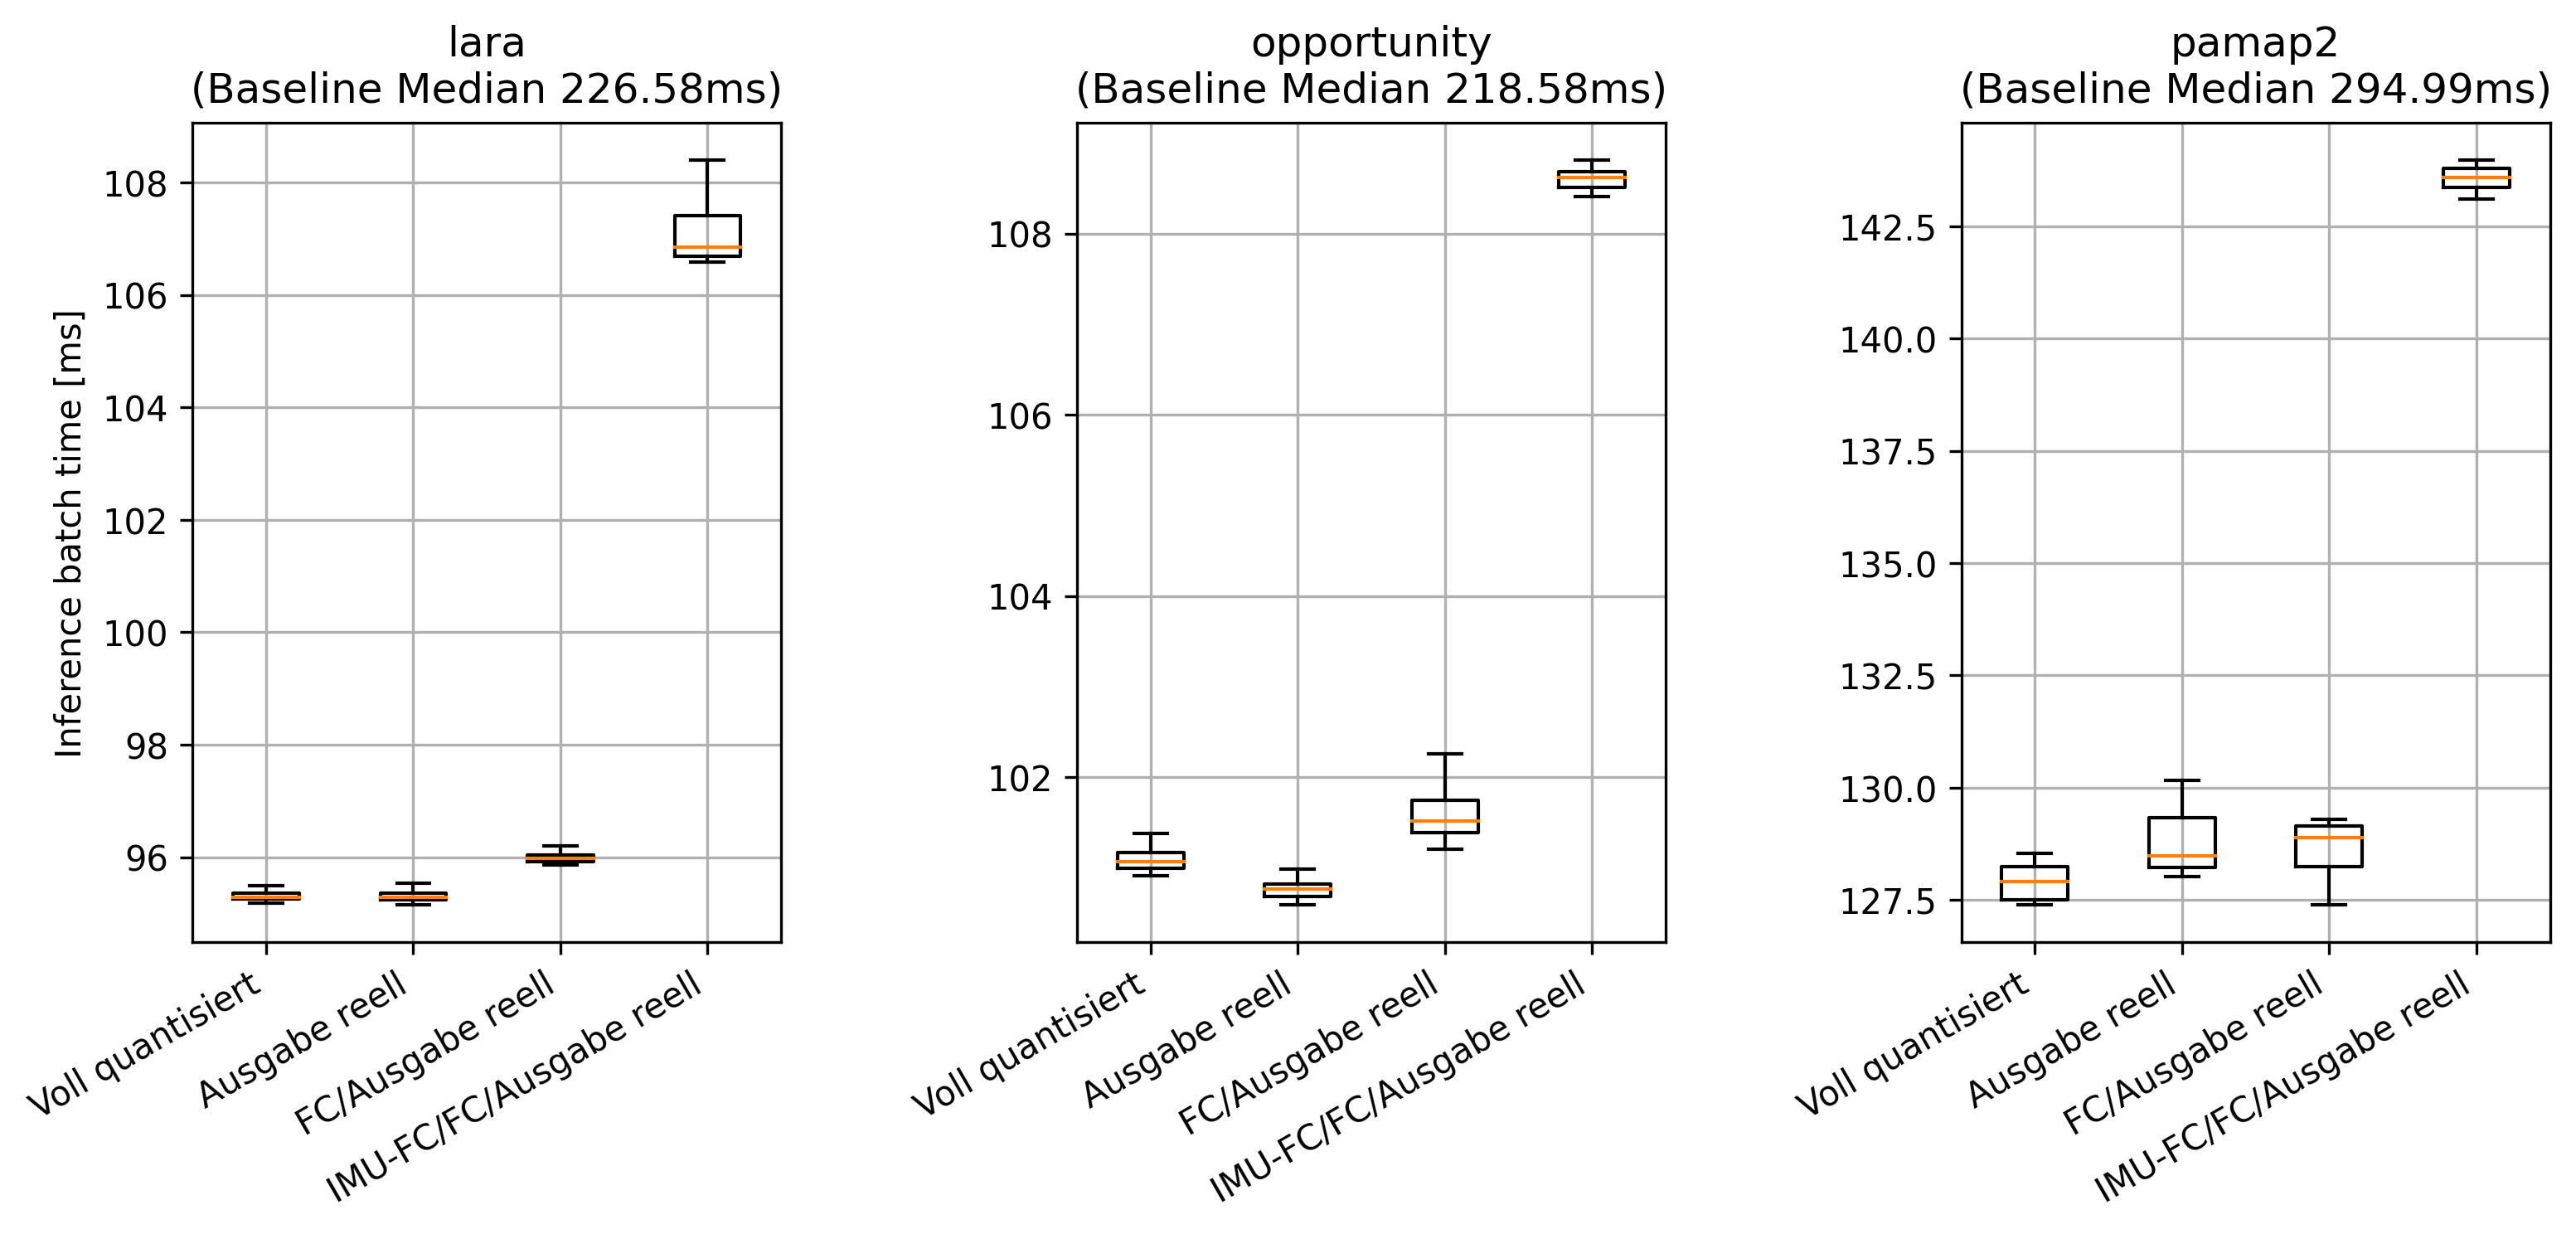

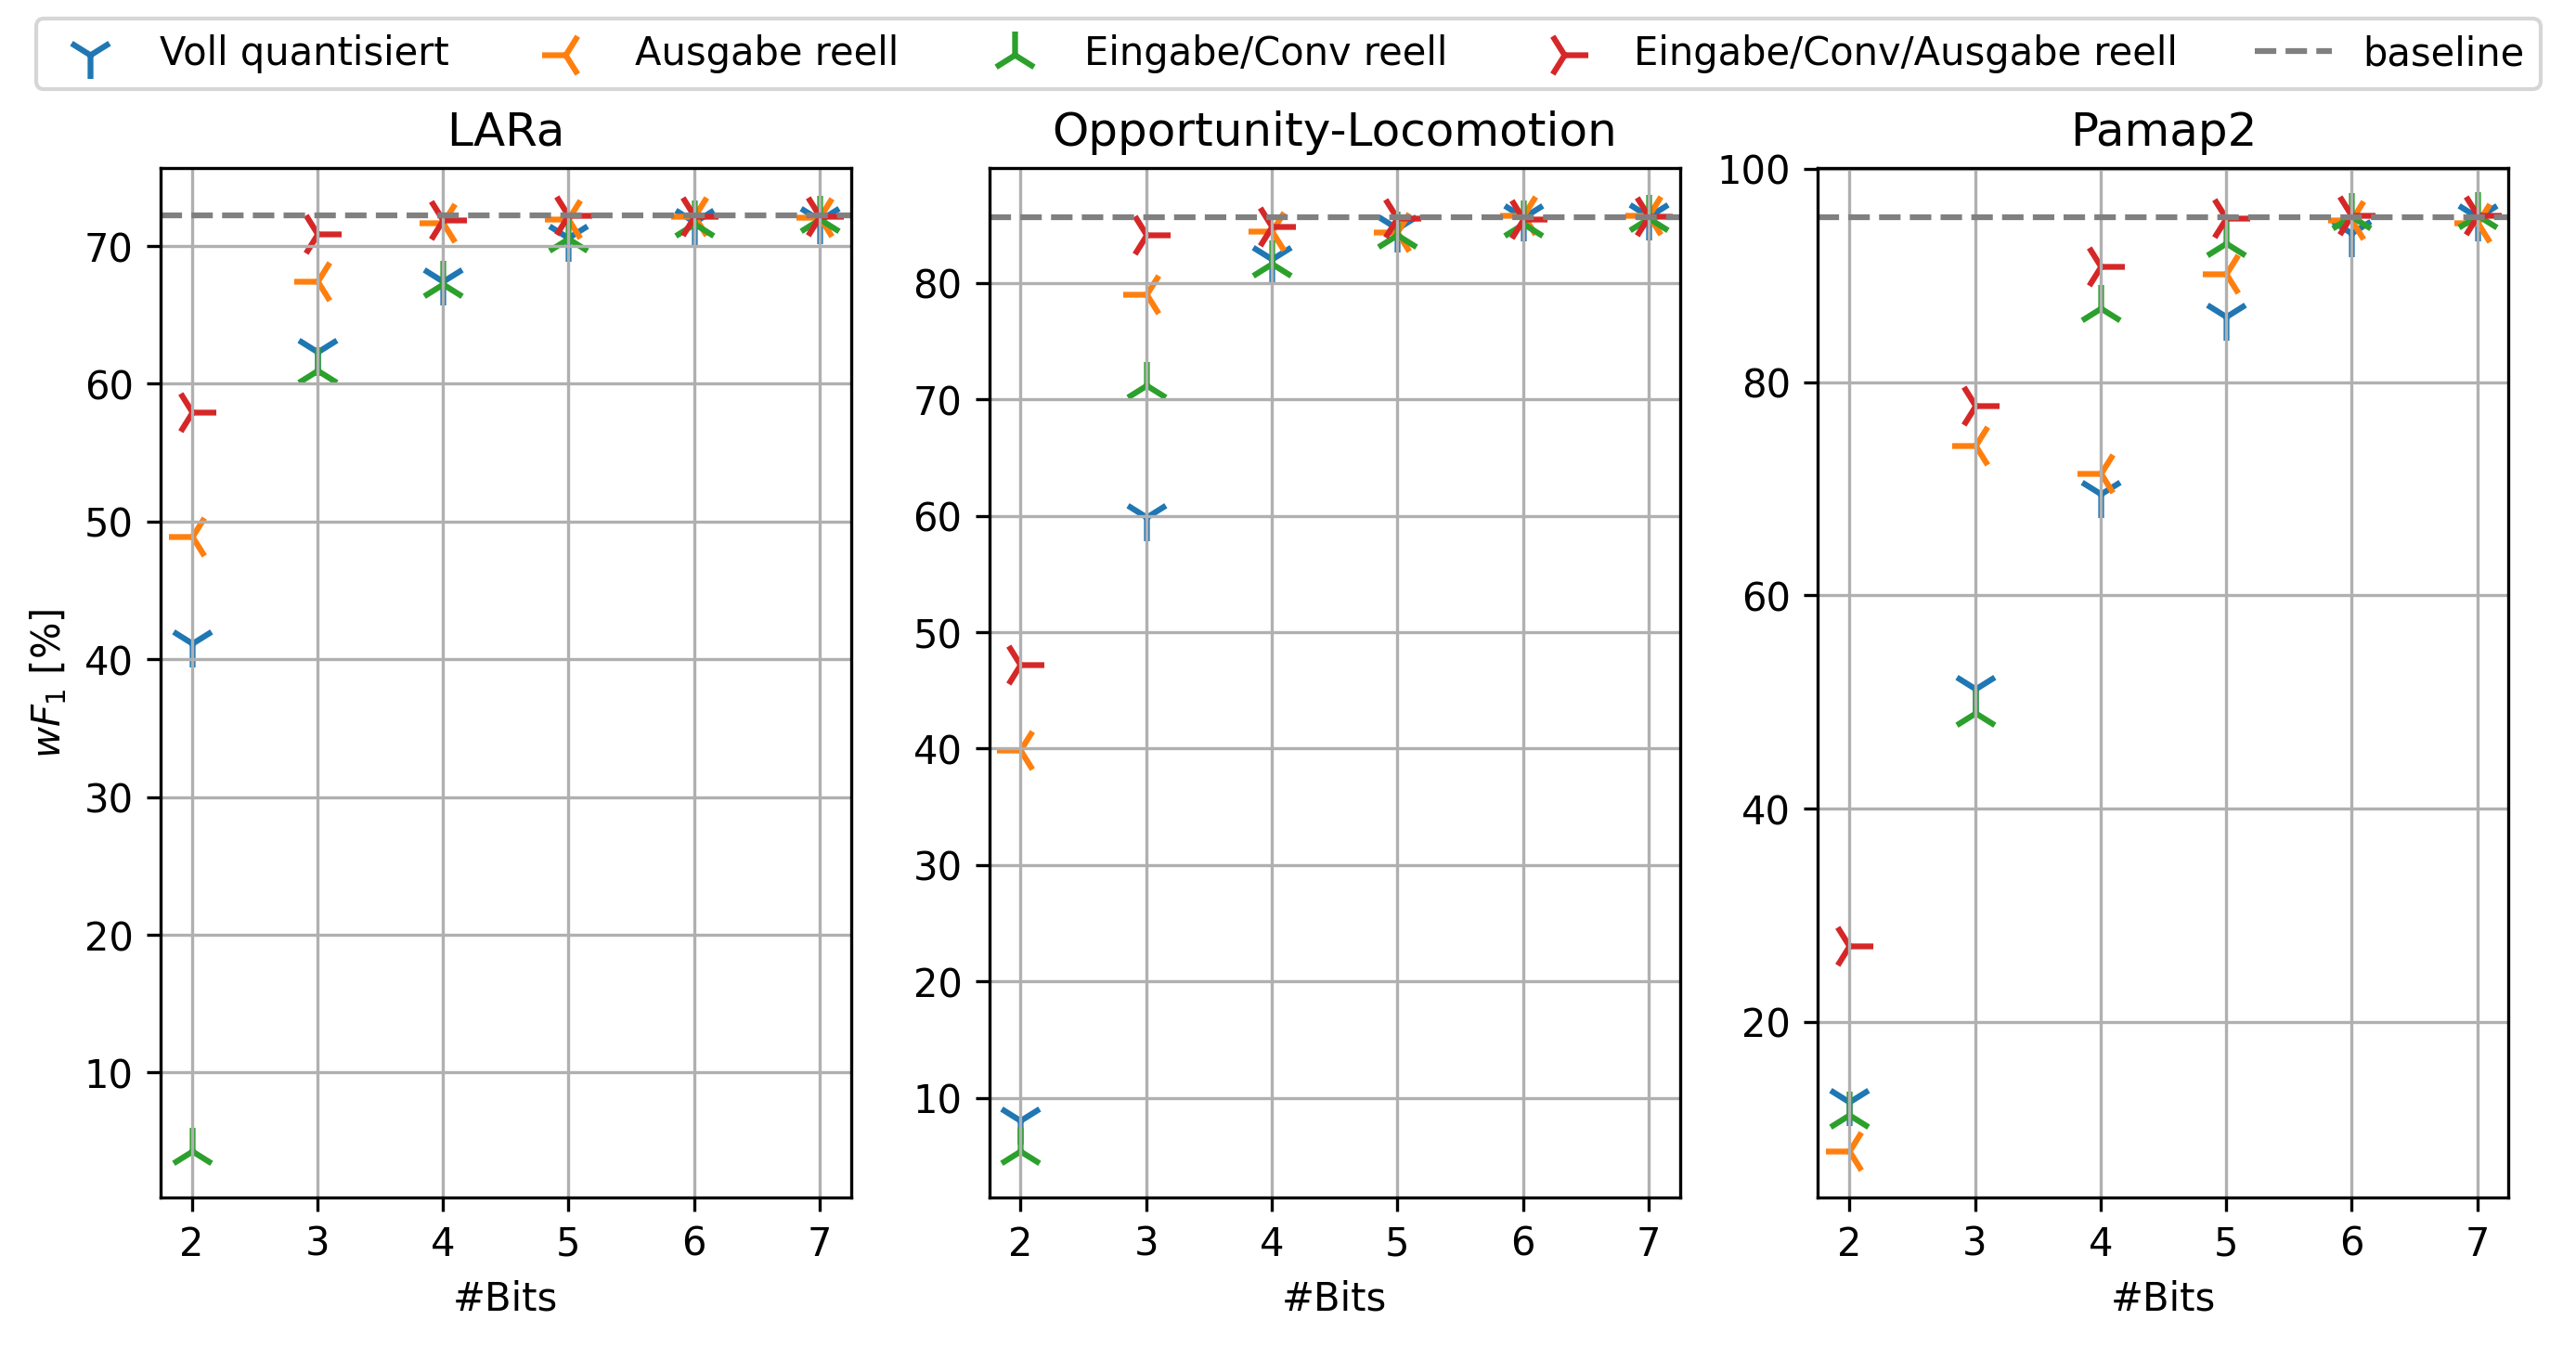

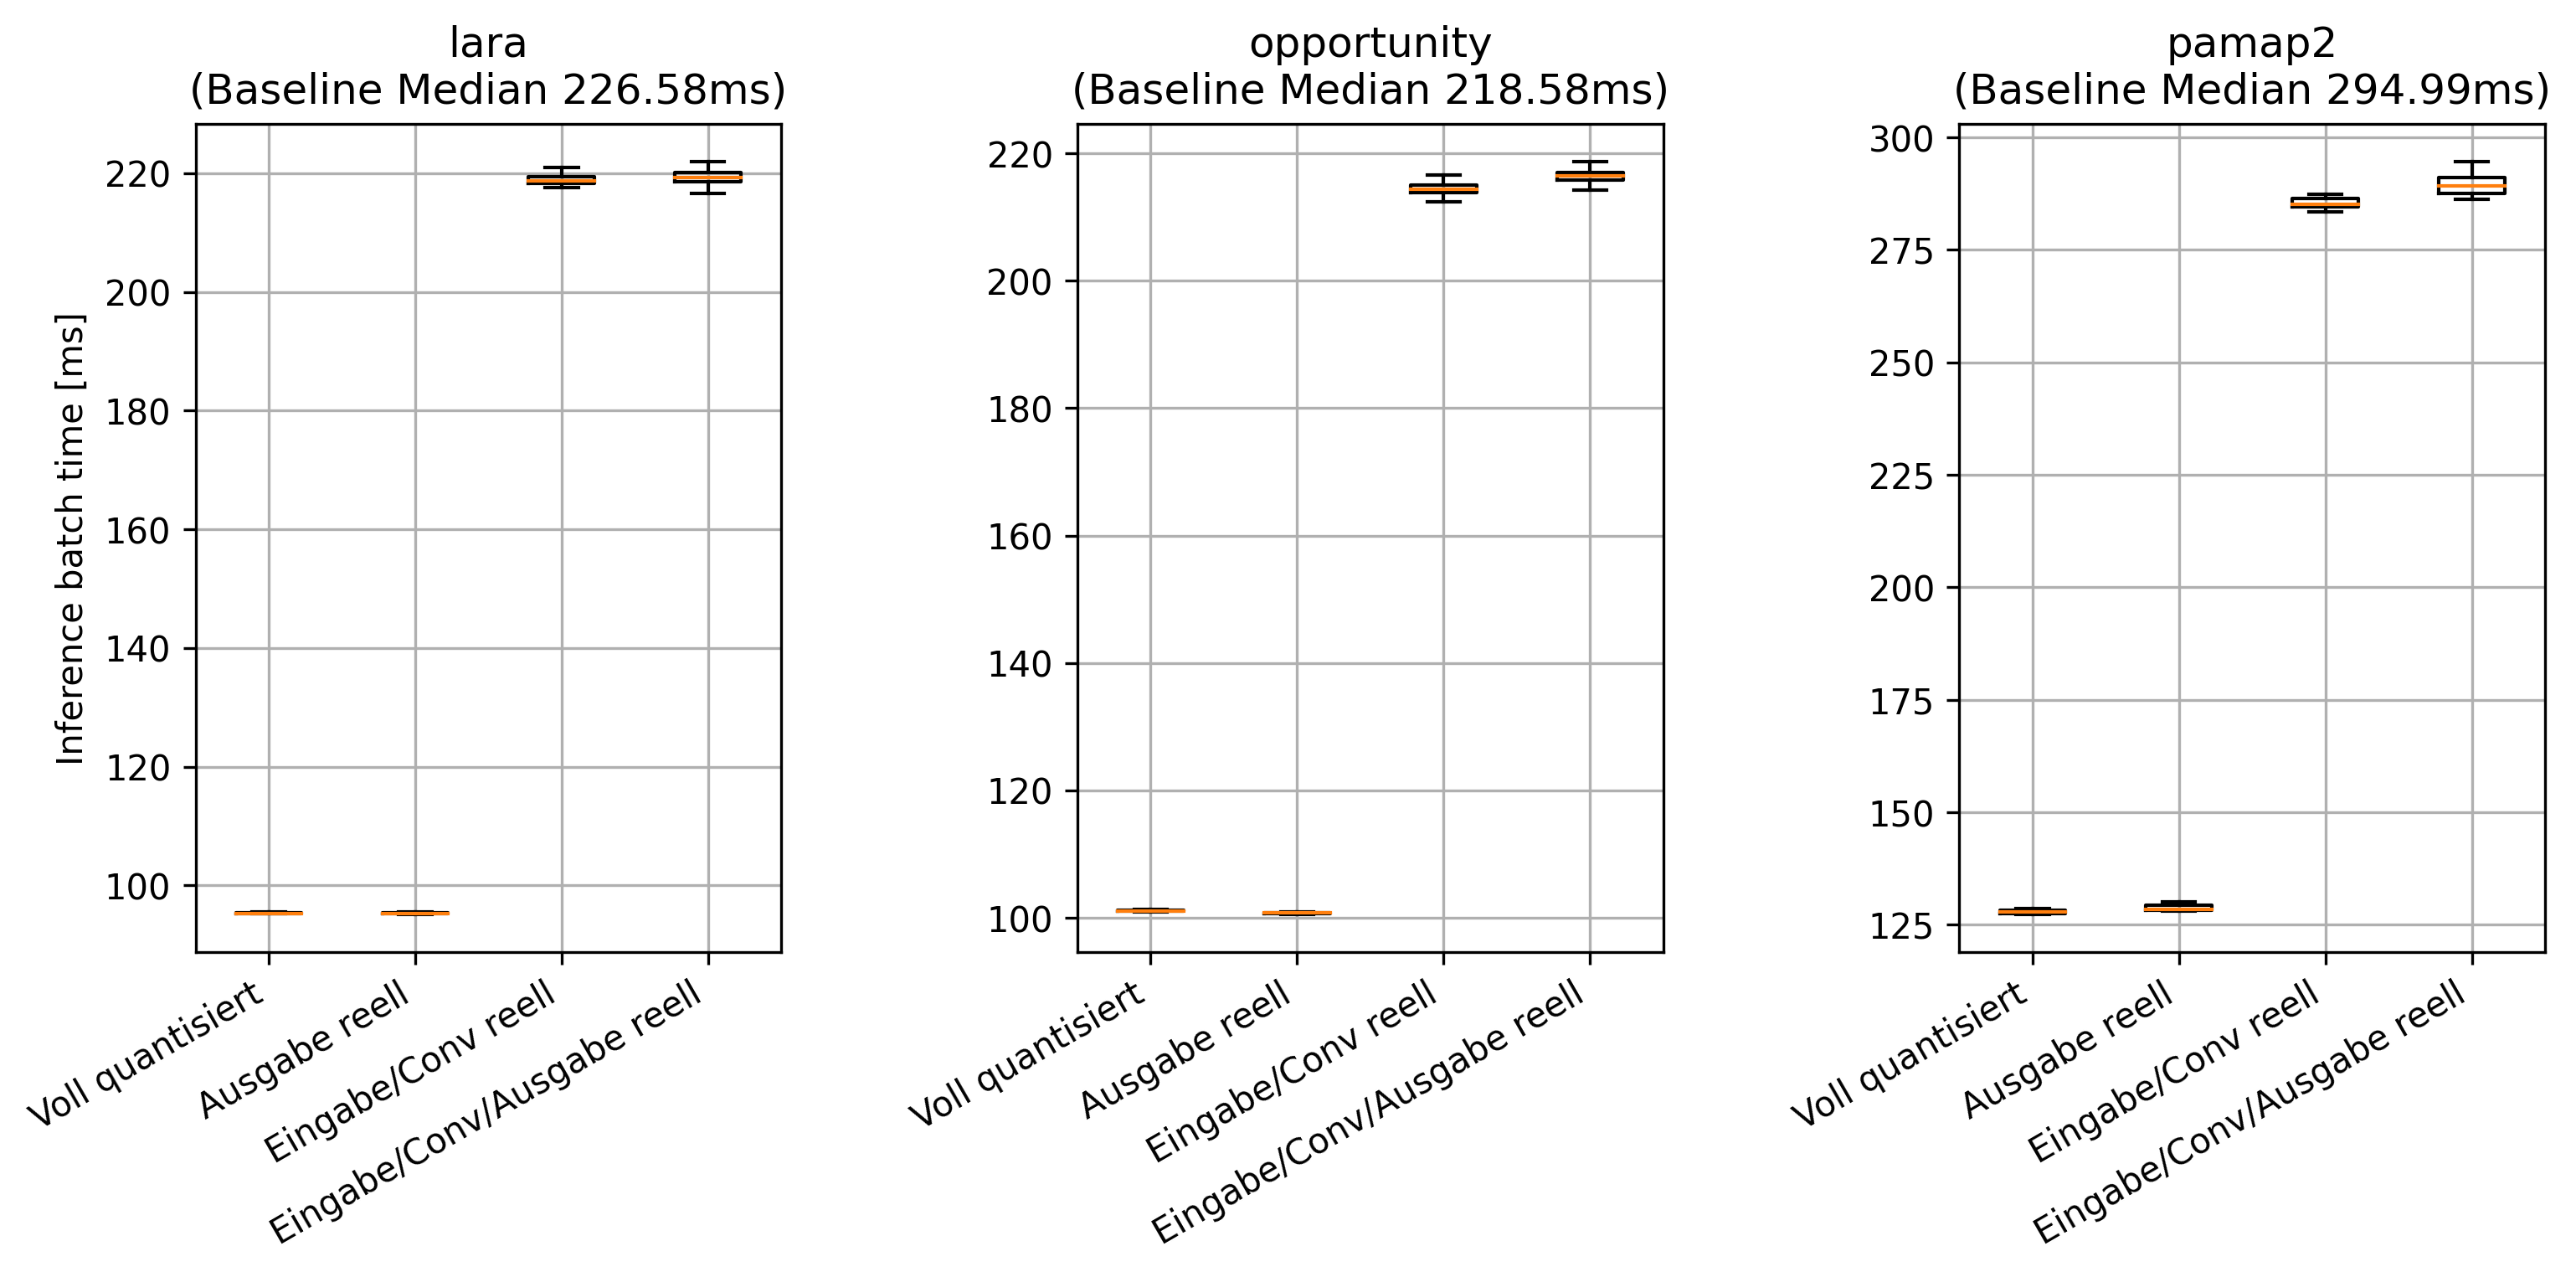

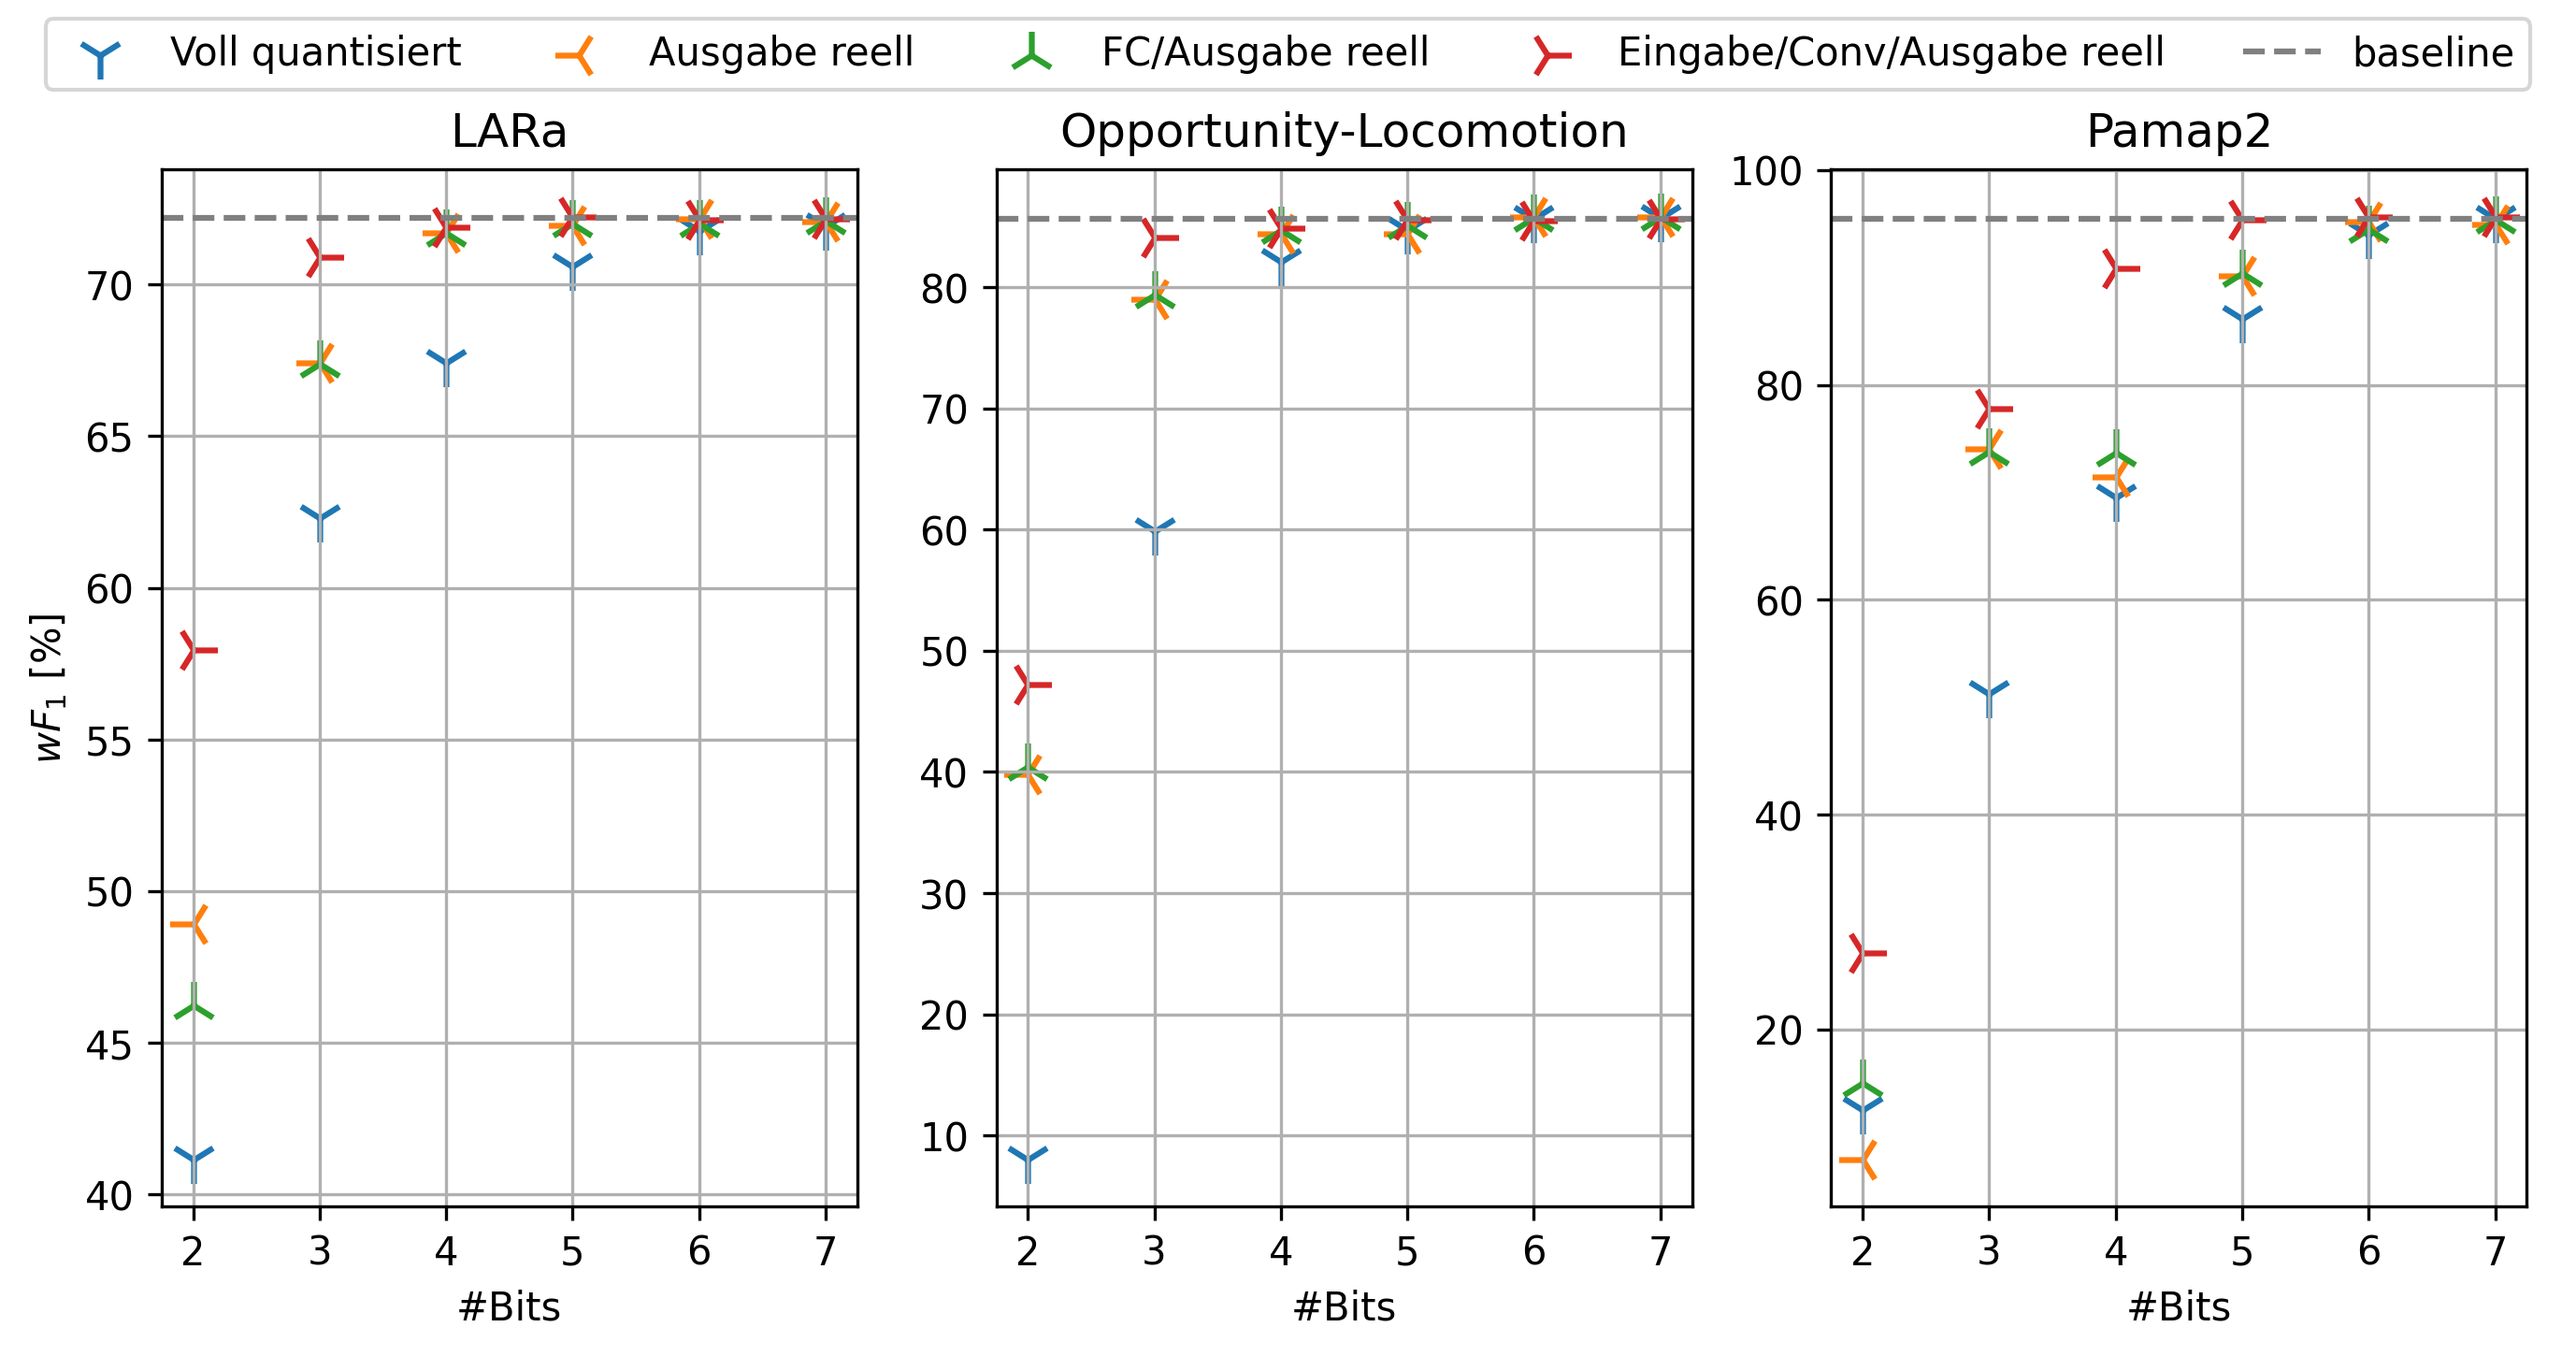

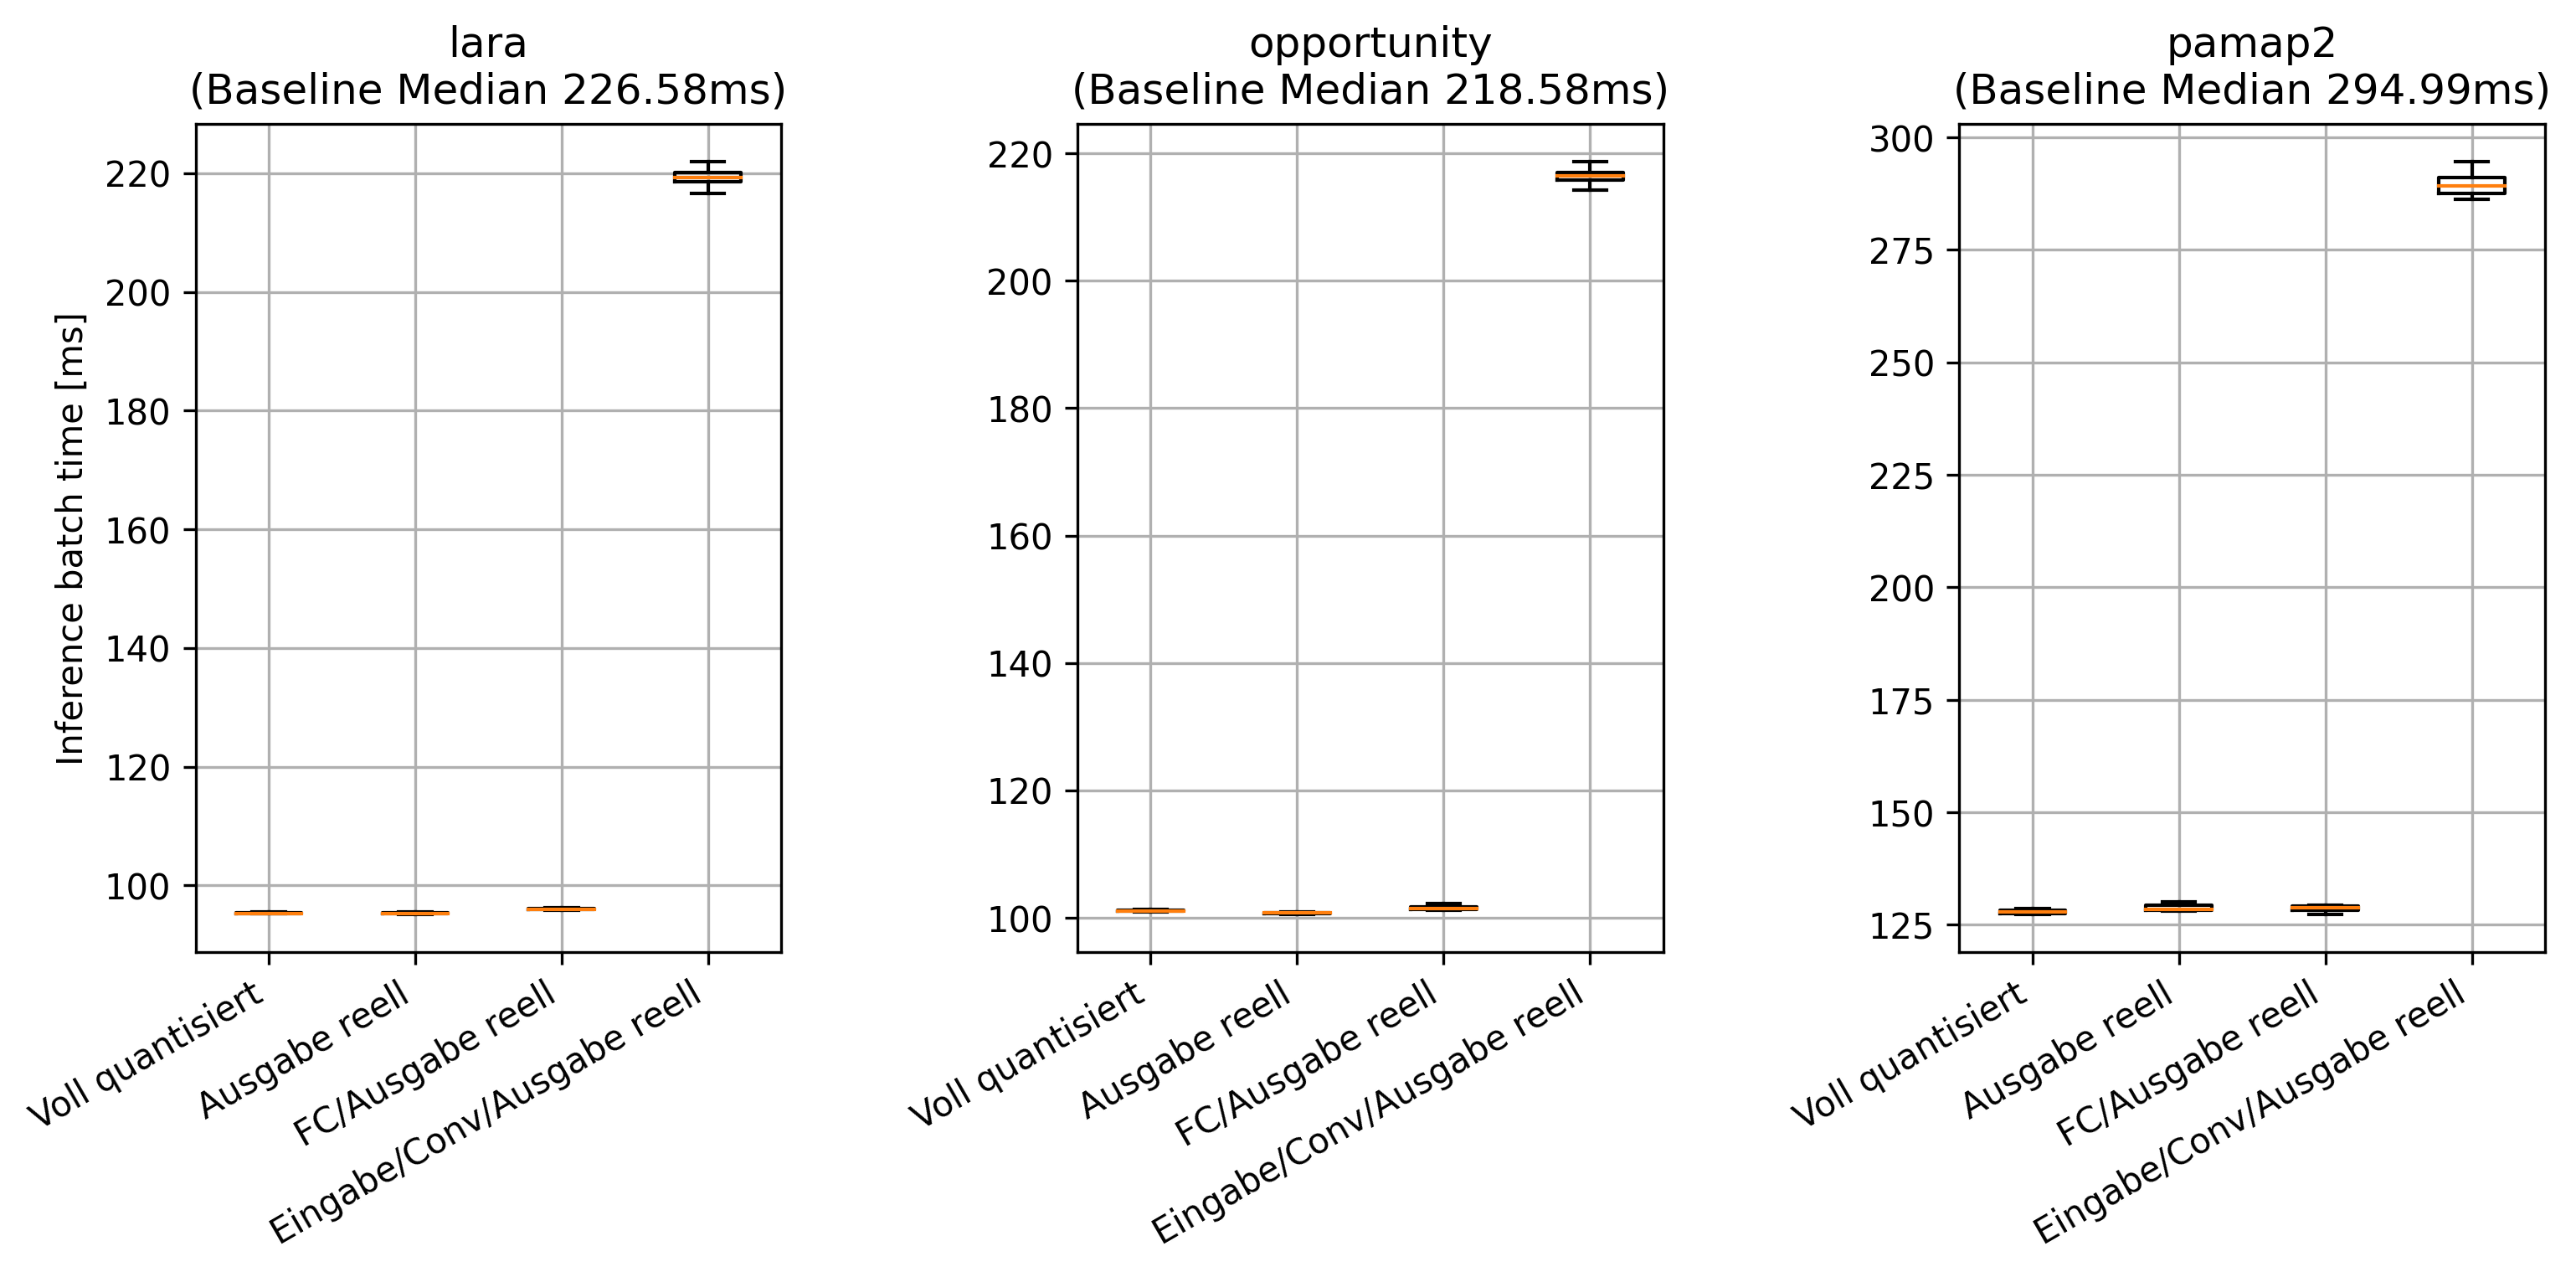

In [9]:
from common.model import CNNIMU
from common.helper import checkpointsById
from common.eval.model import estimateModuleSize

cfg_comparison_1 = {
    'Voll quantisiert': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Eingabe reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Ausgabe reell': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
    'Eingabe/Ausgabe reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
}

cfg_comparison_2 = {
    'Voll quantisiert': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Ausgabe reell': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
    'FC/Ausgabe reell': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'none',
        'output_layer_quantization': 'none',
    },
    'IMU-FC/FC/Ausgabe reell': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'none',
        'fc_quantization': 'none',
        'output_layer_quantization': 'none',
    },
}

cfg_comparison_3 = {
    'Voll quantisiert': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Ausgabe reell': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
    'Eingabe/Conv reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'none',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Eingabe/Conv/Ausgabe reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'none',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
}

cfg_comparison_4 = {
    'Voll quantisiert': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Ausgabe reell': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
    'FC/Ausgabe reell': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'none',
        'output_layer_quantization': 'none',
    },
    'Eingabe/Conv/Ausgabe reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'none',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
}

markers = [
    '1', '3', '2', '4',
    '1', '3', '2', '4',
]
cmap = cm.get_cmap('tab10')

for cfg_comparison in (cfg_comparison_1, cfg_comparison_2, cfg_comparison_3, cfg_comparison_4):
  ex_by_bits_by_cfg_by_dataset = defaultdict(lambda: defaultdict(dict))
  for key, cfg in cfg_comparison.items():
    for ex in mode_vairance_experiments:
      cfg_subset = configSubset(ex, cfg.keys())
      if cfg_subset == cfg:
        bits = ex.to_dict()['config']['n_bits']
        dataset = ex.to_dict()['config']['use_dataset']
        d = ex_by_bits_by_cfg_by_dataset[dataset][key]
        assert bits not in d
        d[bits] = ex

  ex_by_bits_by_cfg_by_dataset = {
      dataset: {
          key: dict(sorted(ex_by_bits.items(), key=lambda x: x[0], reverse=True))
          for key, ex_by_bits in ex_by_bits_by_cfg.items()
      } for dataset, ex_by_bits_by_cfg in ex_by_bits_by_cfg_by_dataset.items()
  }

  labels, handles = [], []

  # Clasification performance plots
  fig, axs = plt.subplots(1, len(ex_by_bits_by_cfg_by_dataset))
  fig.set_dpi(300)
  fig.set_figwidth(fig.get_figwidth() * 1.7)
  for ix, (dataset, ex_by_bits_by_cfg) in enumerate(ex_by_bits_by_cfg_by_dataset.items()):
    s_xs = []
    for k_ix, (key, ex_by_bits) in enumerate(ex_by_bits_by_cfg.items()):
      s_xs = np.array(list(ex_by_bits.keys()))
      s_ys = np.array([e.metrics['test/wf1'] for e in ex_by_bits.values()])

      axs[ix].scatter(x=s_xs, y=s_ys * 100, label=key, color=cmap(k_ix), marker=markers[k_ix], s=150)

    baseline_wf1 = base_experiment_by_dataset[dataset].metrics['test/wf1'].max() * 100
    axs[ix].axhline(y=baseline_wf1, color='grey', linestyle='dashed', label='baseline')

    axs[ix].set_xticks(s_xs)
    axs[ix].set_xlabel('#Bits')
    if ix == 0:
        axs[ix].set_ylabel('$wF_1$ [%]')
    axs[ix].grid()
    axs[ix].set_title(friendly[dataset])
    handles, labels = axs[ix].get_legend_handles_labels()

  fig.legend(handles, labels, loc='upper center', ncol=len(ex_by_bits_by_cfg)+1)
  fig.show()

  # Time performance plots
  fig, axs = plt.subplots(1, len(ex_by_bits_by_cfg_by_dataset))
  fig.set_dpi(300)
  fig.set_figwidth(fig.get_figwidth() * 1.7)
  for ix, (dataset, ex_by_bits_by_cfg) in enumerate(ex_by_bits_by_cfg_by_dataset.items()):
    b_xs = []
    b_labels = []
    b_colors = []
    for k_ix, (key, ex_by_bits) in enumerate(ex_by_bits_by_cfg.items()):
      b_xs.append(ex_by_bits[7].metrics['test/batch_time'] * 1000)
      b_labels.append(key)
      b_colors.append(cmap(k_ix))

    baseline_median = base_experiment_by_dataset[dataset].metrics['test/batch_time'].median() * 1000

    axs[ix].boxplot(x=b_xs, labels=b_labels, showfliers=False)

    if ix == 0:
        axs[ix].set_ylabel('Inference batch time [ms]')
    axs[ix].grid()
    axs[ix].set_title(f'{dataset}\n(Baseline Median {baseline_median:.02f}ms)')

  fig.tight_layout()
  fig.autofmt_xdate()
  fig.show()

# Memory decrease by selected configuration

/home/jroeger/bachelor_thesis_code/.venv/lib/python3.9/site-packages/torch/ao/quantization/utils.py:287: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


\begin{tabular}{rllllllll}
\hline
   \#Bits & Voll quantisiert                           & Eingabe reell                              & Ausgabe reell                              & Eingabe/Ausgabe reell                      & FC/Ausgabe reell                           & IMU-FC/FC/Ausgabe reell                      & Eingabe/Conv reell                         & Eingabe/Conv/Ausgabe reell                 \\
\hline
        7 & {L: $22.93$MB\\O: $13.57$MB\\P: $29.81$MB} & {L: $23.26$MB\\O: $14.81$MB\\P: $30.08$MB} & {L: $22.94$MB\\O: $13.57$MB\\P: $29.83$MB} & {L: $23.27$MB\\O: $14.81$MB\\P: $30.09$MB} & {L: $27.04$MB\\O: $17.46$MB\\P: $33.11$MB} & {L: $103.85$MB\\O: $58.34$MB\\P: $135.52$MB} & {L: $23.90$MB\\O: $17.25$MB\\P: $30.59$MB} & {L: $23.91$MB\\O: $17.25$MB\\P: $30.61$MB} \\
        6 & {L: $19.65$MB\\O: $11.63$MB\\P: $25.55$MB} & {L: $19.99$MB\\O: $12.92$MB\\P: $25.83$MB} & {L: $19.67$MB\\O: $11.63$MB\\P: $25.57$MB} & {L: $20.01$MB\\O: $12.92$MB\\P: $25.85$MB} & {L: $23.93$MB\\O:

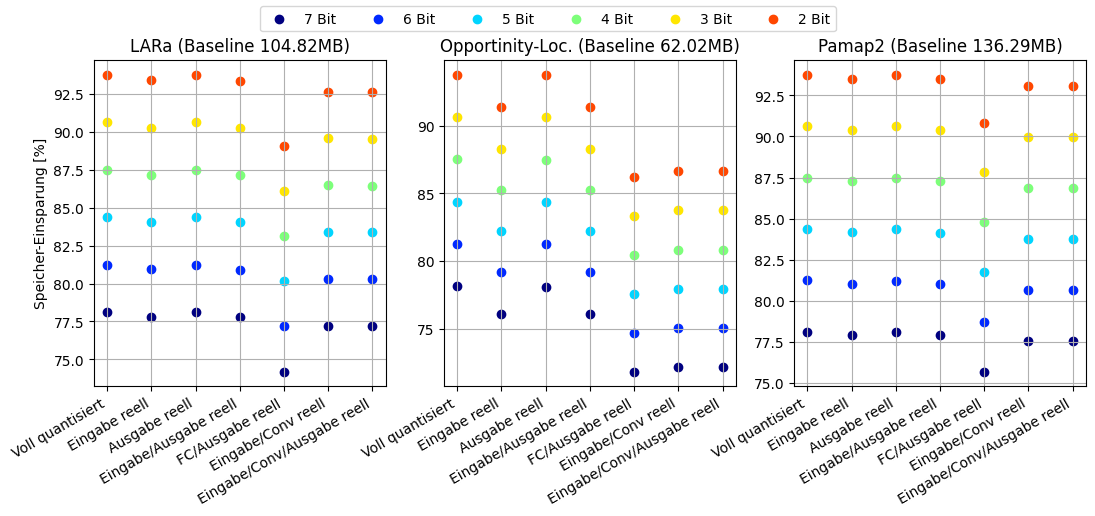

In [10]:
import logging
from copy import deepcopy

merged_configs = cfg_comparison_1 | cfg_comparison_2 | cfg_comparison_3

ex_by_cfg_by_bits_by_dataset = defaultdict(lambda: defaultdict(dict))
for key, cfg in merged_configs.items():
  for ex in mode_vairance_experiments:
    cfg_subset = configSubset(ex, cfg.keys())
    if cfg_subset == cfg:
      bits = ex.to_dict()['config']['n_bits']
      dataset = ex.to_dict()['config']['use_dataset']
      d = ex_by_cfg_by_bits_by_dataset[dataset][bits]
      assert key not in d
      d[key] = ex

ex_by_cfg_by_bits_by_dataset = {
    dataset: dict(sorted(ex_by_cfg_by_bits.items(), key=lambda x: x[0], reverse=True))
    for dataset, ex_by_cfg_by_bits in ex_by_cfg_by_bits_by_dataset.items()
}

friendly_local = {
  'lara' : 'LARa',
  'opportunity' : 'Opportinity-Loc.',
  'pamap2' : 'Pamap2',
}
#ex_by_cfg_by_bits_by_dataset = {
#    dataset: {
#        bits: dict(sorted(ex_by_cfg.items(), key=lambda x: x[0], reverse=True))
#        for bits, ex_by_cfg in ex_by_cfg_by_bits.items()
#    } for dataset, ex_by_cfg_by_bits in ex_by_cfg_by_bits_by_dataset.items()
#}

logging.getLogger().setLevel(logging.CRITICAL)
model_by_cfg_by_dataset = {
    dataset: {
        cfg: CNNIMU.load_from_checkpoint(
            checkpointsById(root='../logs/checkpoints', run_id=ex.to_dict()['_id'])['model'])
        for cfg, ex in ex_by_cfg_by_bits[7].items()
    } for dataset, ex_by_cfg_by_bits in ex_by_cfg_by_bits_by_dataset.items()
}

cmap = cm.get_cmap('jet')

memory_dataset_by_bits_by_config = defaultdict(lambda: defaultdict(dict))

fig, axs = plt.subplots(1, len(ex_by_cfg_by_bits_by_dataset))
fig.set_figwidth(fig.get_figwidth() * 2)
handles, labels = [], []
for ix, (dataset, ex_by_cfg_by_bits) in enumerate(ex_by_cfg_by_bits_by_dataset.items()):
  baseline_model = CNNIMU.load_from_checkpoint(
      checkpointsById(root='../logs/checkpoints',
                      run_id=base_experiment_by_dataset[dataset].to_dict()['_id'])['best_wf1'])
  baseline_memory = estimateModuleSize(module=baseline_model, n_bits=0)

  for b_ix, (bits, ex_by_cfg) in enumerate(ex_by_cfg_by_bits.items()):
    xs = list(range(len(ex_by_cfg)-1))
    labels = []
    ys = []

    for cfg, ex in ex_by_cfg.items():
      memory = estimateModuleSize(module=model_by_cfg_by_dataset[dataset][cfg], n_bits=bits)
      memory_dataset_by_bits_by_config[cfg][bits][dataset] = memory
      if cfg == 'IMU-FC/FC/Ausgabe reell':
        continue
      labels.append(cfg)
      ys.append(memory)

    ys = 100 * (1 - (np.array(ys)/baseline_memory))

    axs[ix].scatter(x=xs, y=ys, color=cmap(b_ix/len(ex_by_cfg_by_bits)), label=f'{bits} Bit')
    axs[ix].set_xticks(xs)
    axs[ix].set_xticklabels(labels)

  axs[ix].grid()
  if ix == 0:
    axs[ix].set_ylabel('Speicher-Einsparung [%]')
  axs[ix].set_title(f'{friendly_local[dataset]} (Baseline {(baseline_memory/8)*1e-6:.02f}MB)')
  handles, labels = axs[ix].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', ncol=6)
fig.autofmt_xdate()
fig.show()
logging.getLogger().setLevel(logging.INFO)

def cell(m_by_d) -> str:
  o = m_by_d['opportunity']
  p = m_by_d['pamap2']
  l = m_by_d['lara']
  return f'{{L: ${(l/8)*1e-6:.02f}$MB\\\\O: ${(o/8)*1e-6:.02f}$MB\\\\P: ${(p/8)*1e-6:.02f}$MB}}'

table_header = ['\#Bits'] + list(memory_dataset_by_bits_by_config.keys())
bits = list(memory_dataset_by_bits_by_config.values())[0].keys()
table_data = zip(
    bits,
    *[[cell(m_by_d) for m_by_d in mem_by_d_by_b.values()] for mem_by_d_by_b in memory_dataset_by_bits_by_config.values()])
print(tabulate(tabular_data=table_data, headers=table_header, tablefmt='latex_raw'))

# Load QAT Experiments

In [11]:
all_qat_experiments_query = {
    '$and': [{
        'experiment.name': 'QAT_CNN-IMU'
    }, {
        'status': 'COMPLETED'
    }, {
        '_id': {
            '$gte': 1573
        }
    }]
}
all_qat_experiments = loader.find(all_qat_experiments_query)
print(f'Loaded {len(all_qat_experiments)} QAT Experiments')

base_experiment_by_dataset = {}
for ex in all_qat_experiments:
  cfg = ex.to_dict()['config']
  if cfg['use_dataset'] in base_experiment_by_dataset:
    assert base_experiment_by_dataset[cfg['use_dataset']] == cfg['trained_model_run_id']
  else:
    base_experiment_by_dataset[cfg['use_dataset']] = cfg['trained_model_run_id']
base_experiment_by_dataset = {
    d: loader.find_by_id(e_id) for d, e_id in base_experiment_by_dataset.items()
}
print(f'Base Experiments {base_experiment_by_dataset}')

Loaded 504 QAT Experiments
Base Experiments {'opportunity': Experiment(id=787, name=CNN-IMU_Opportunity-Locomotion), 'pamap2': Experiment(id=788, name=CNN-IMU_Pamap2(activity_labels)), 'lara': Experiment(id=786, name=CNN-IMU_LARa)}


# Compare with QAT Results

504


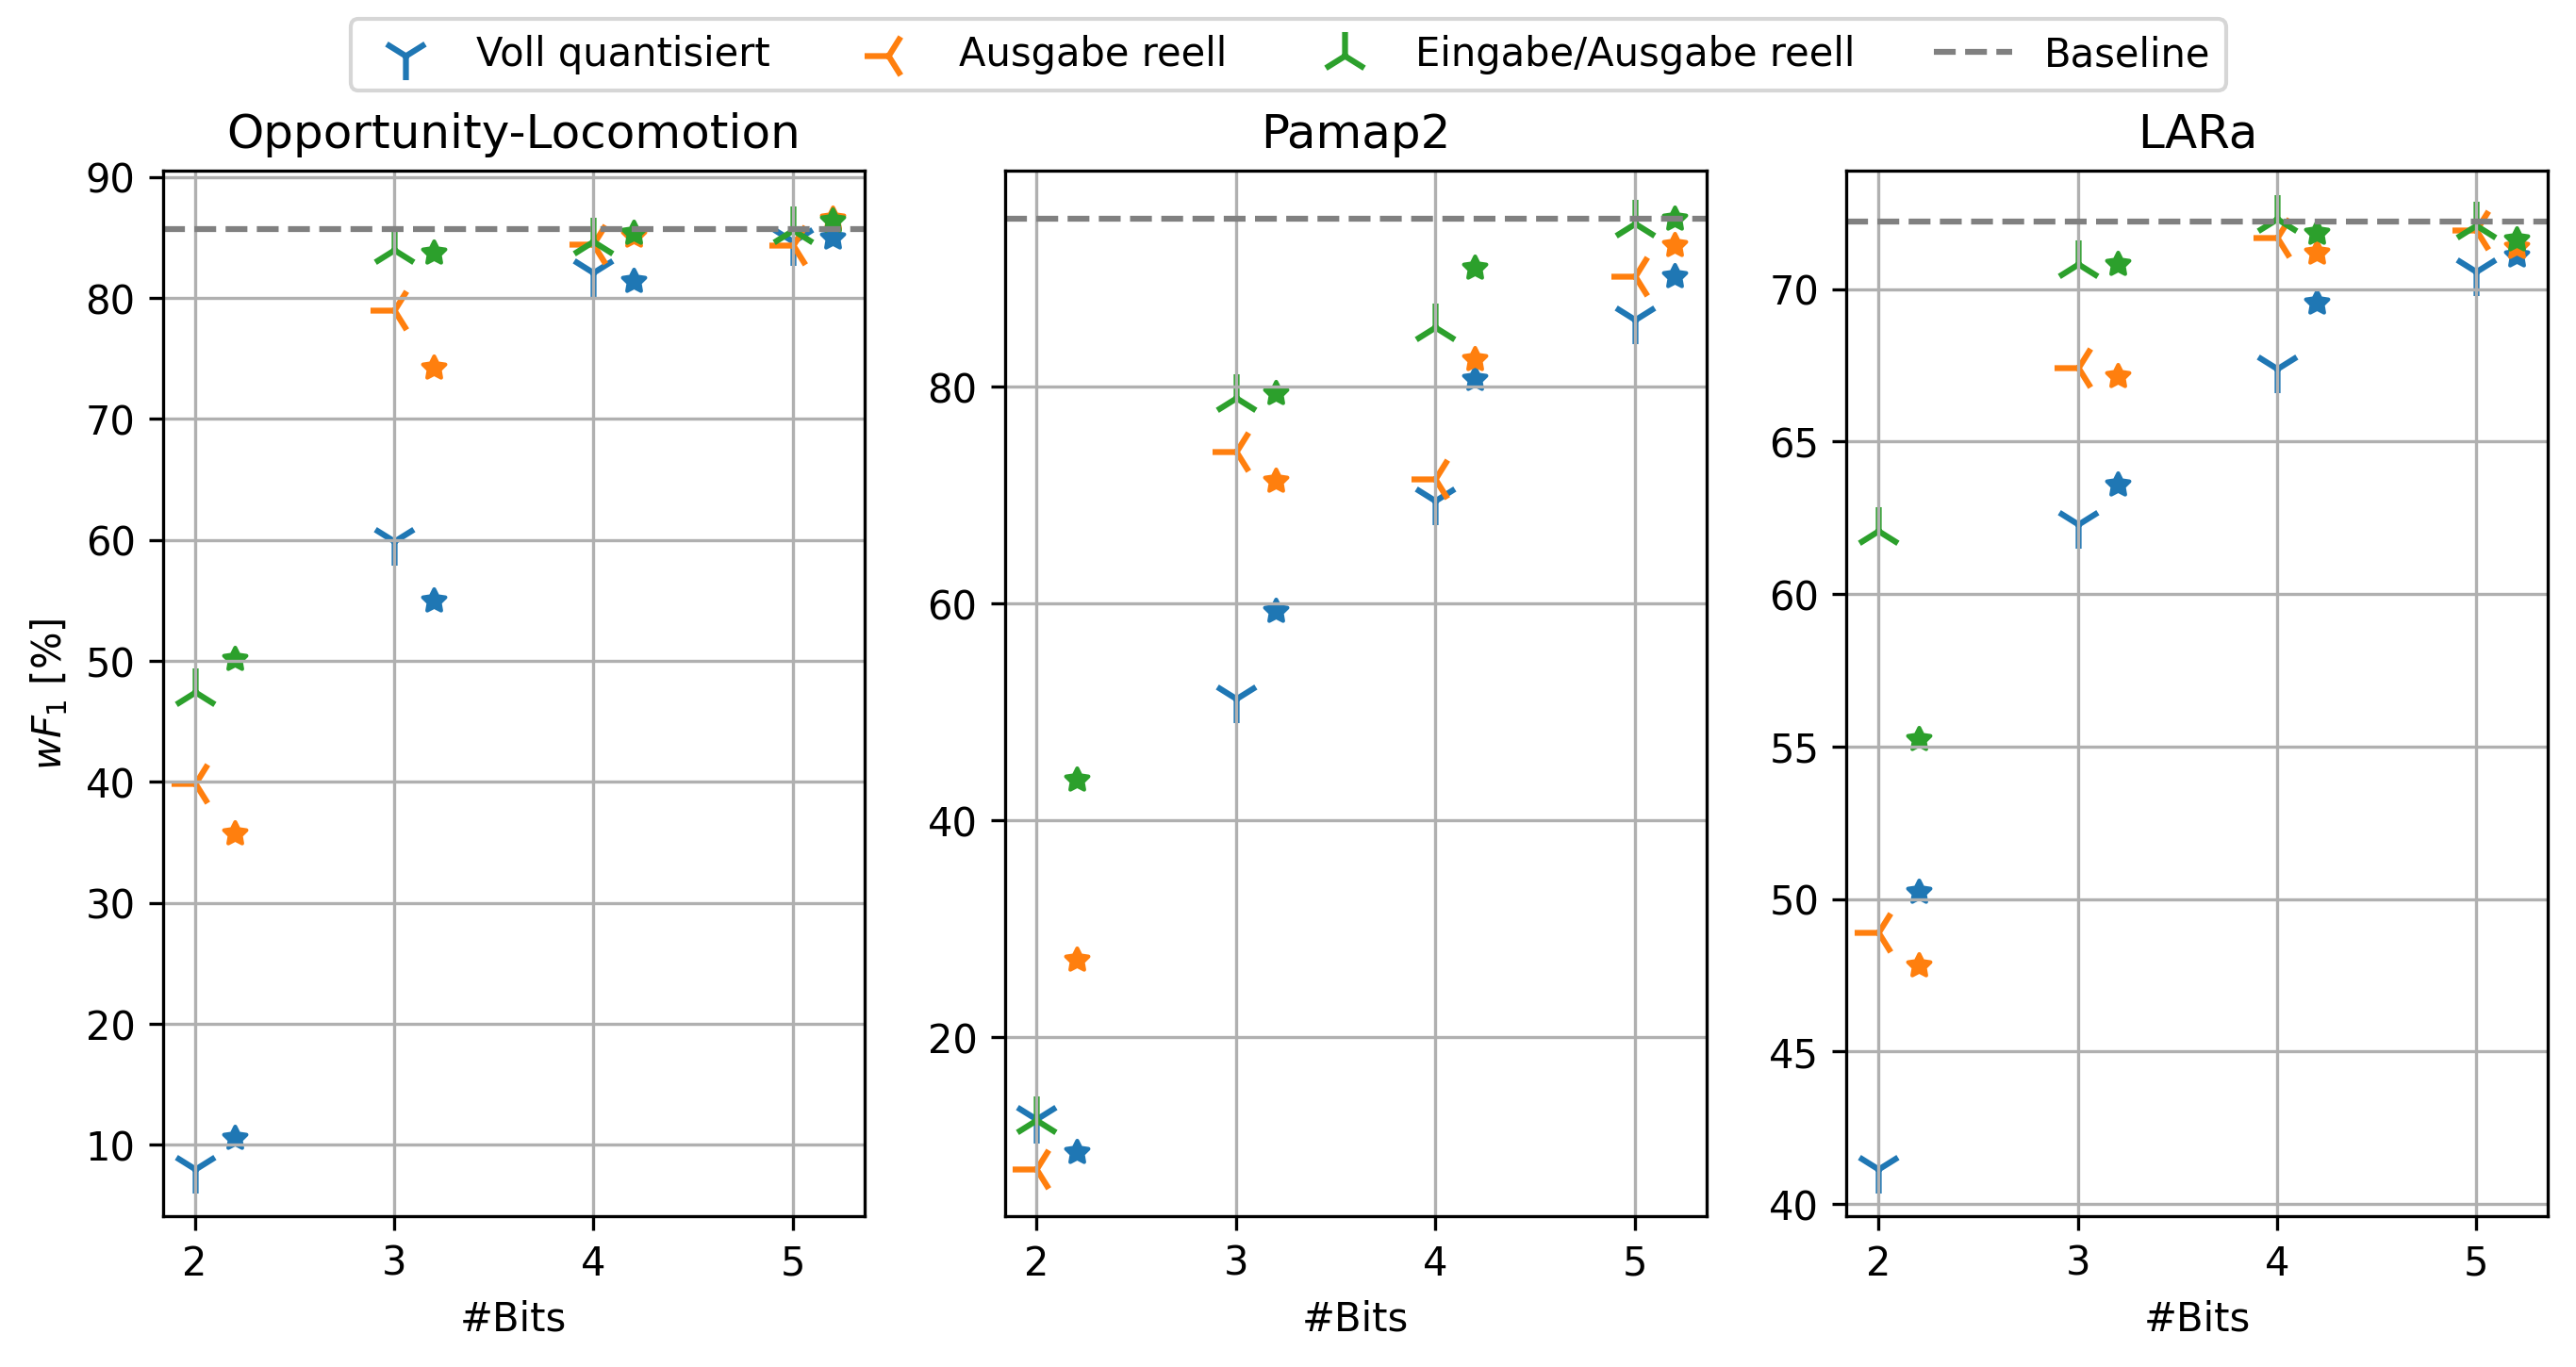

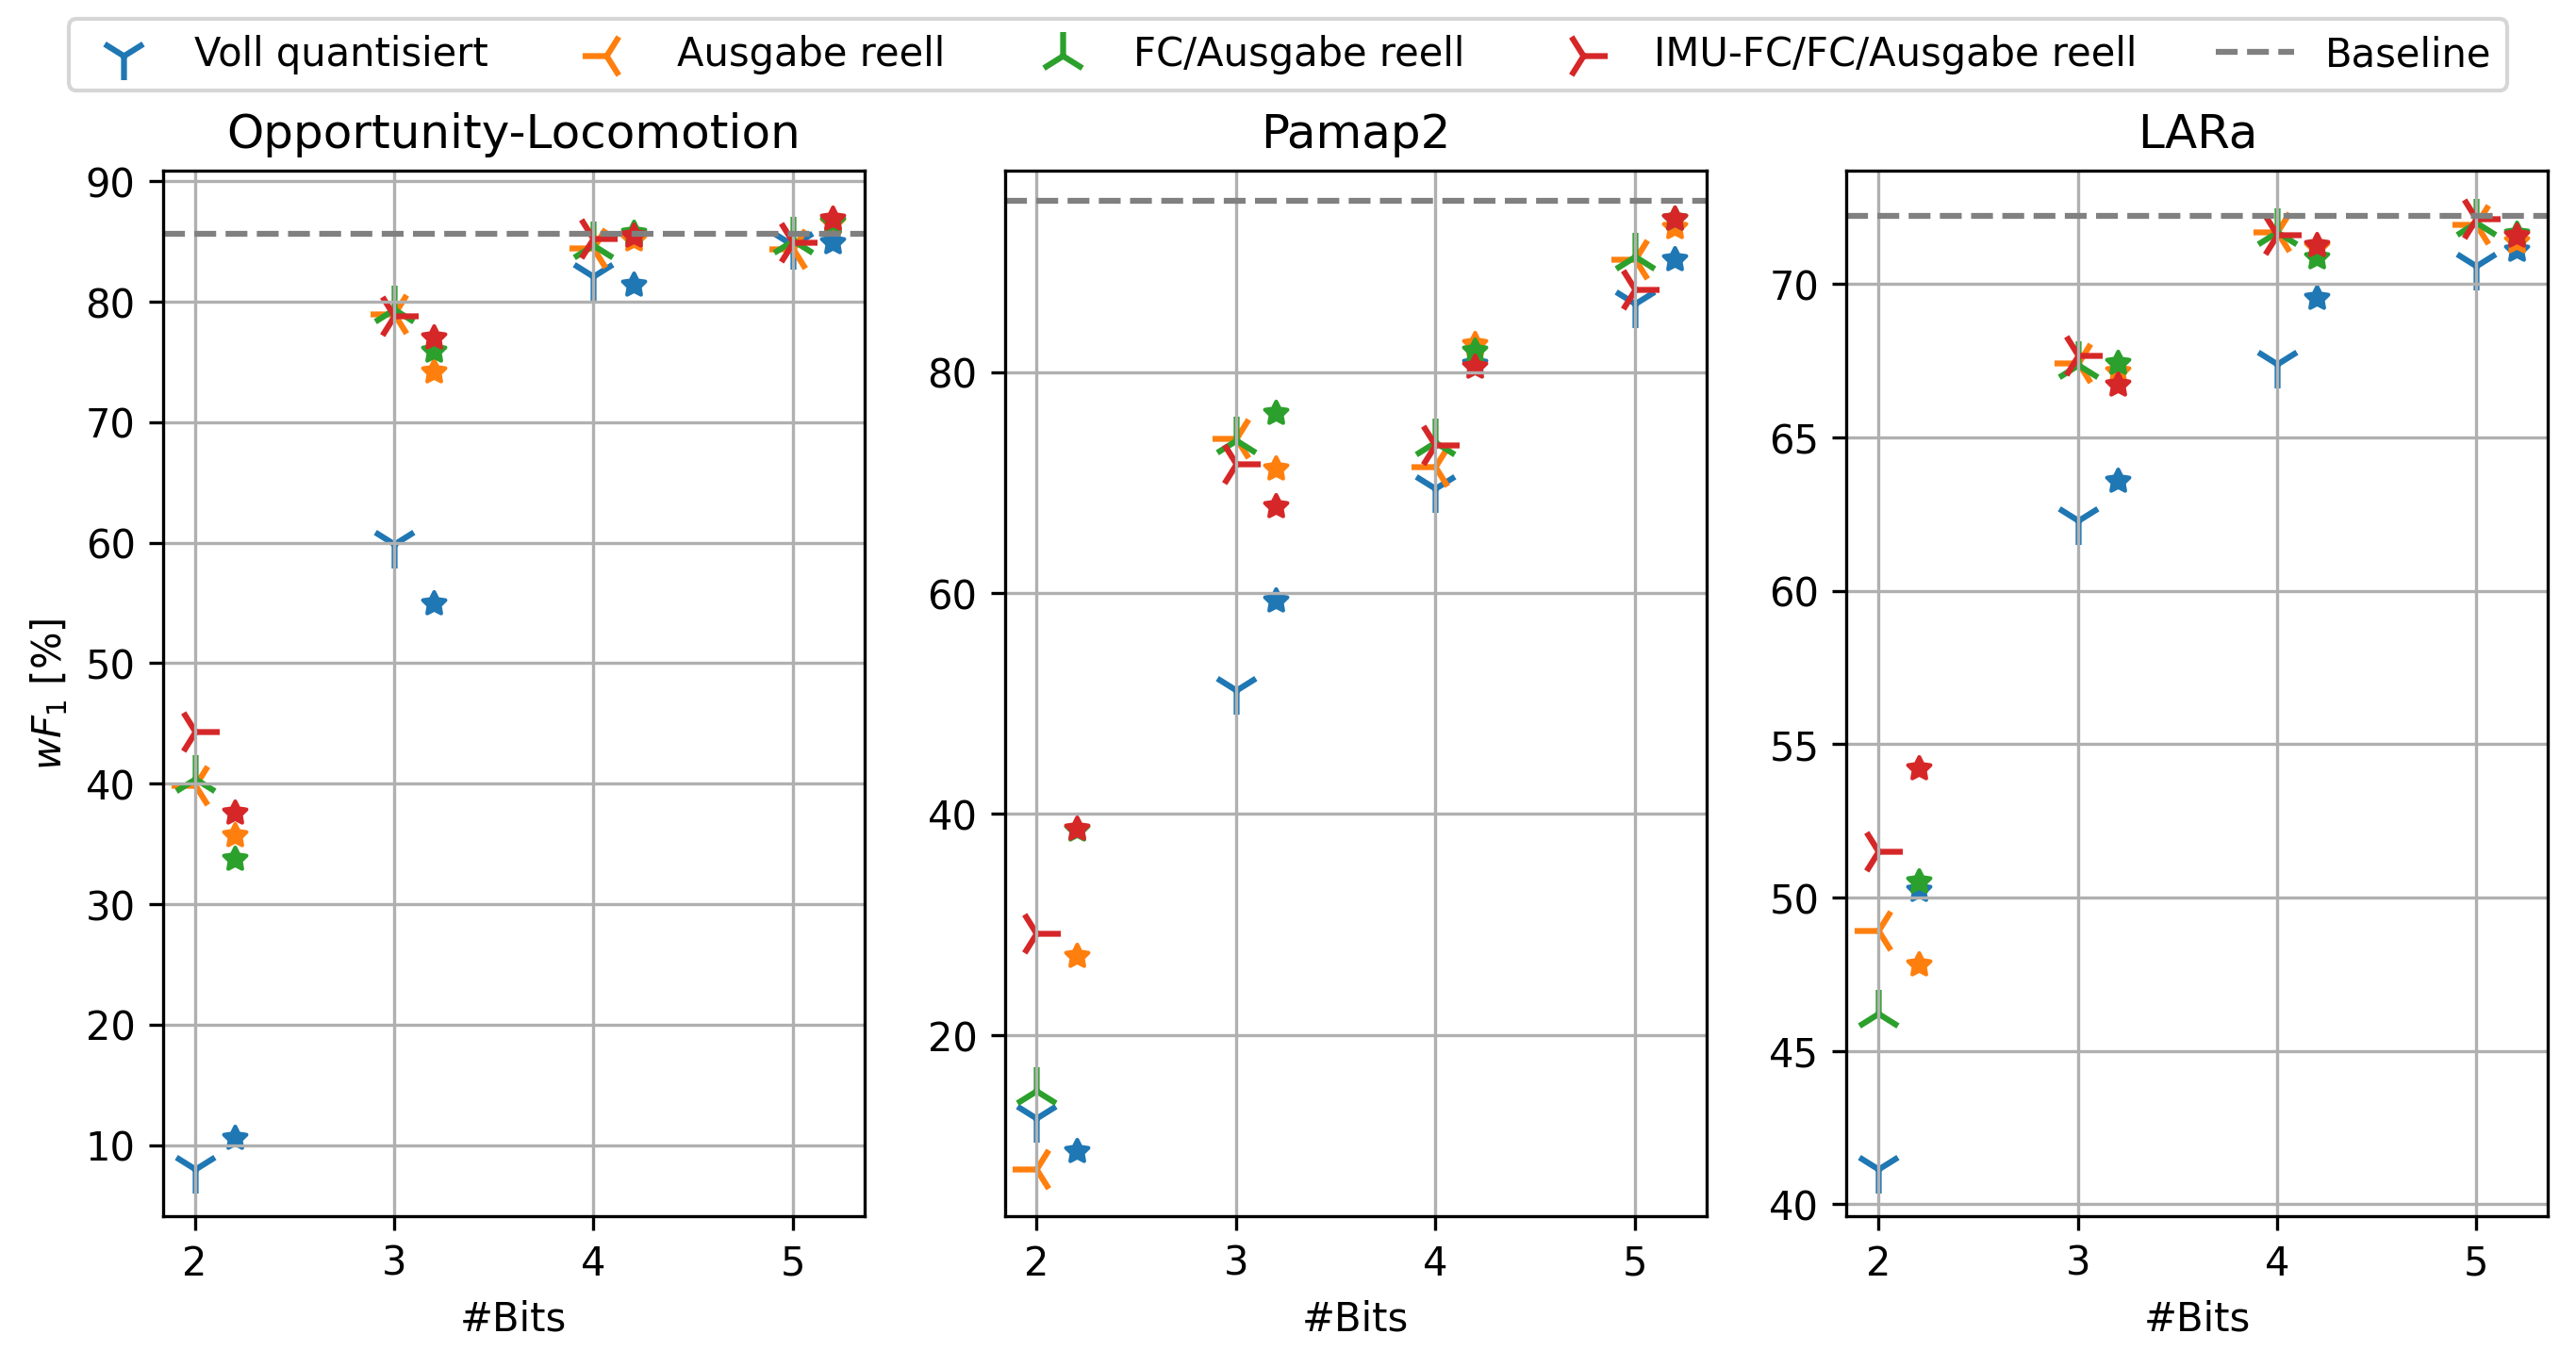

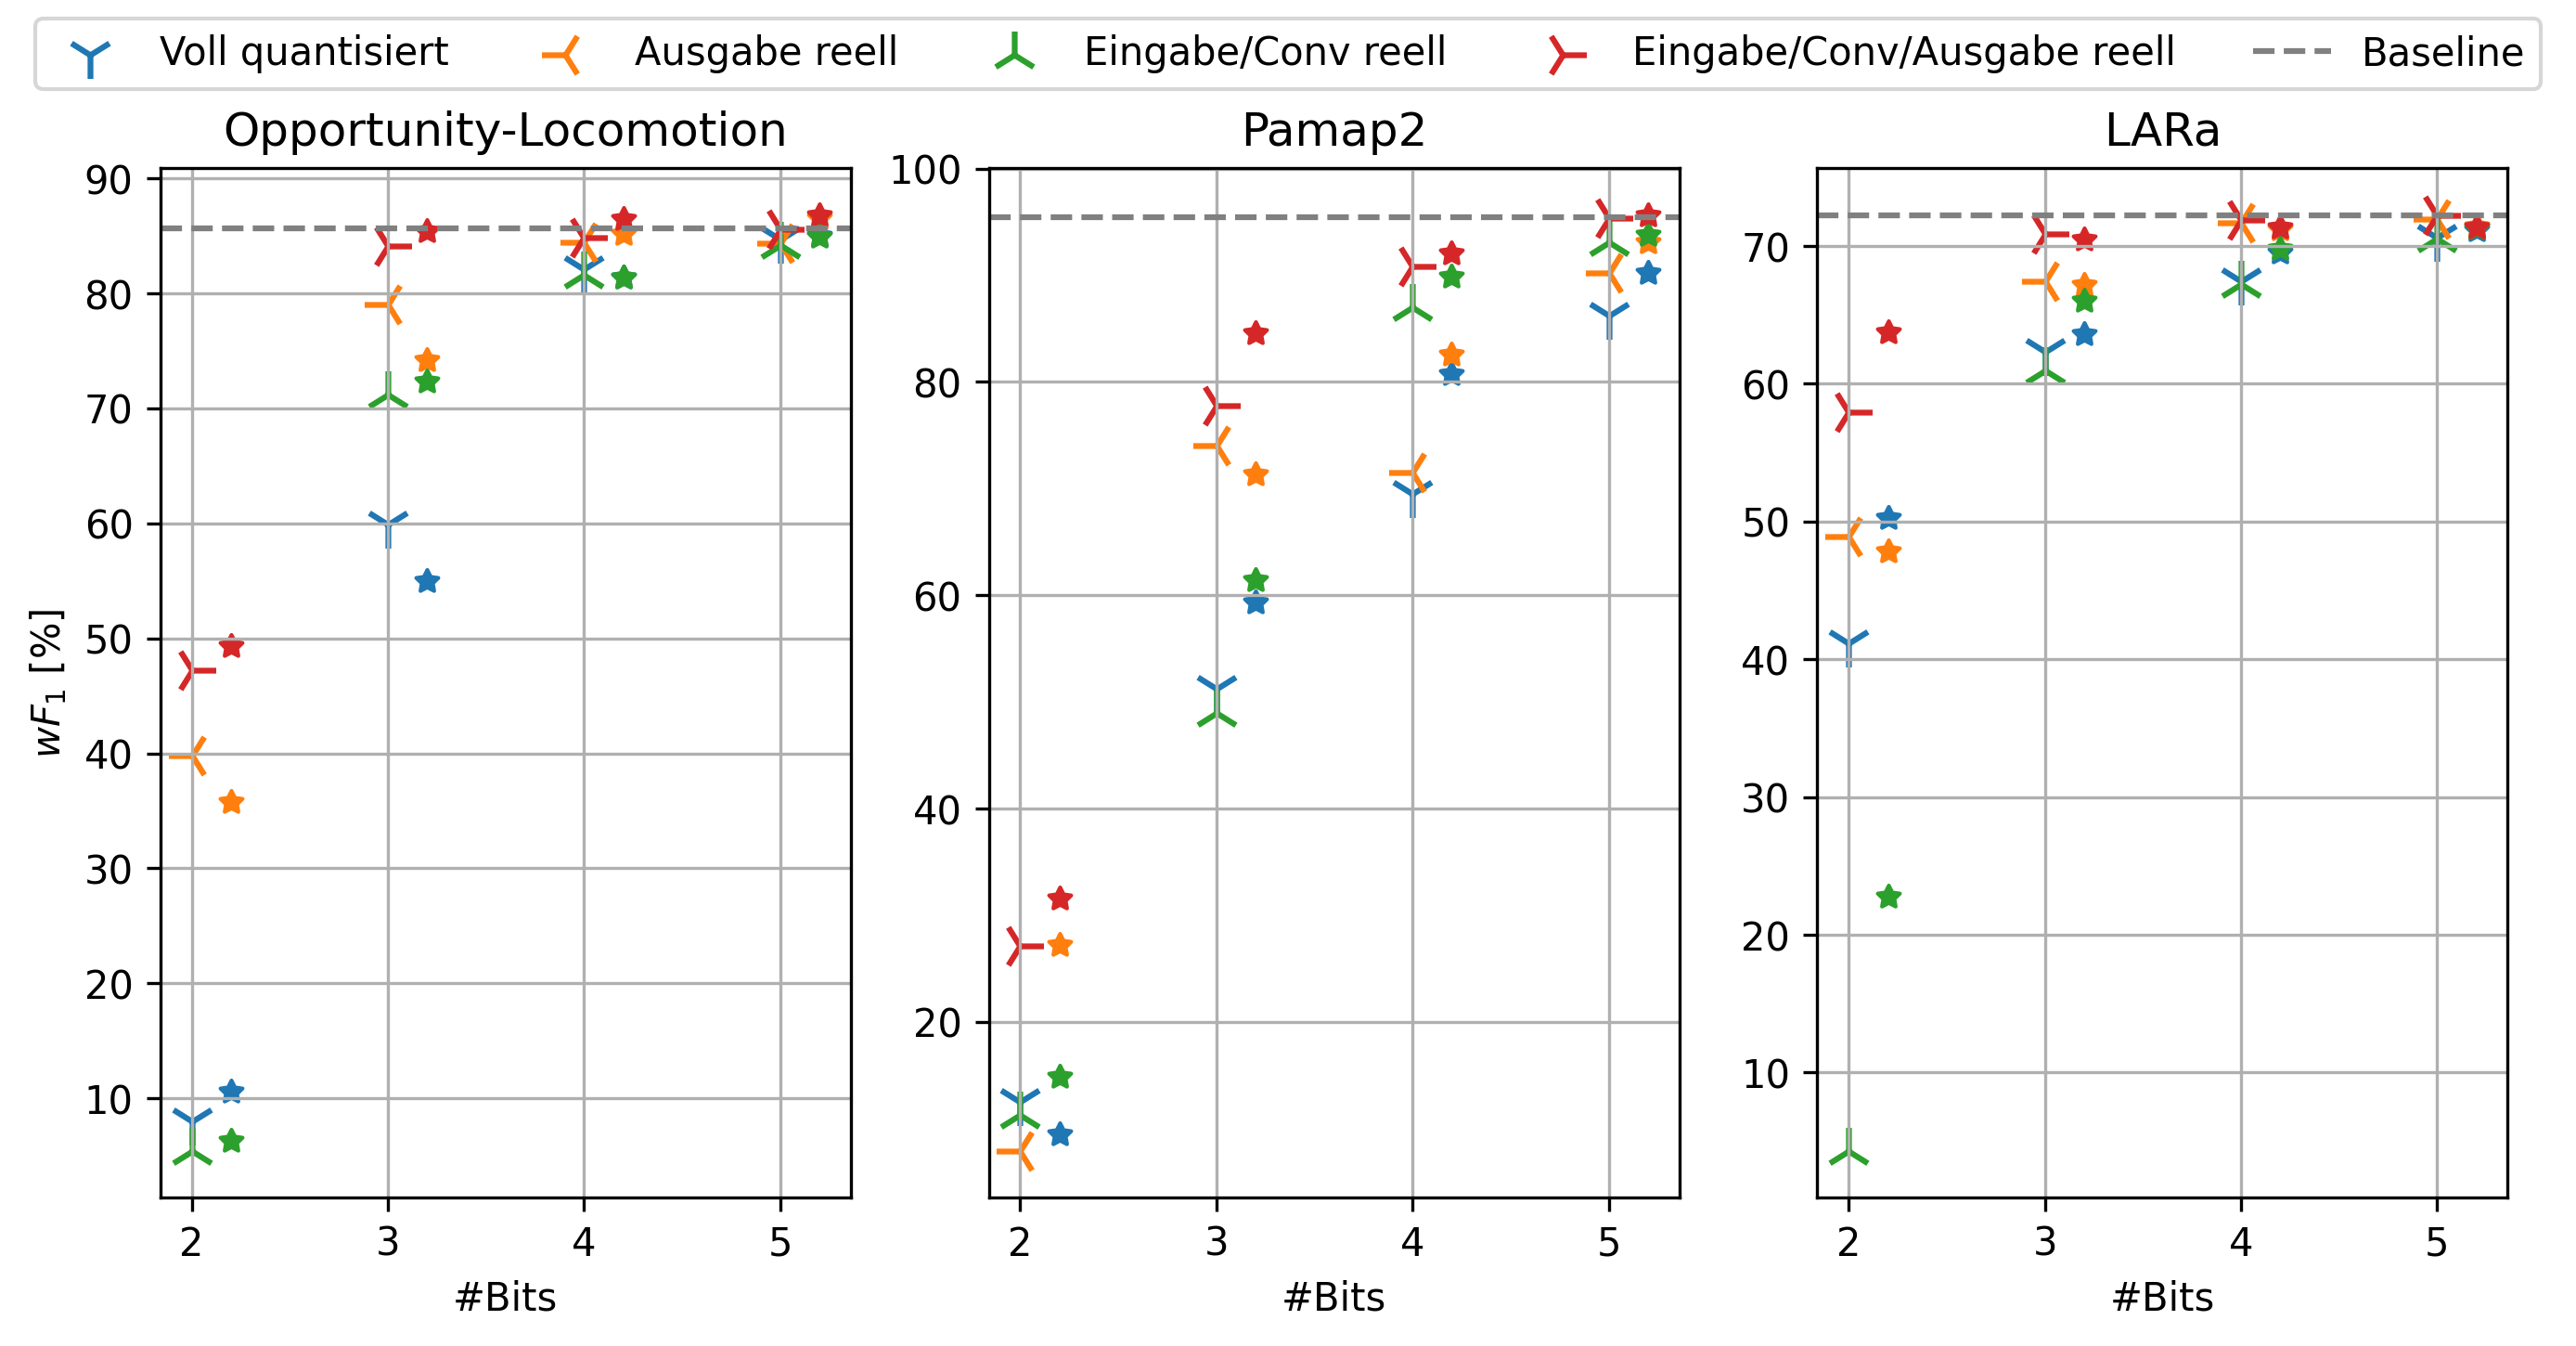

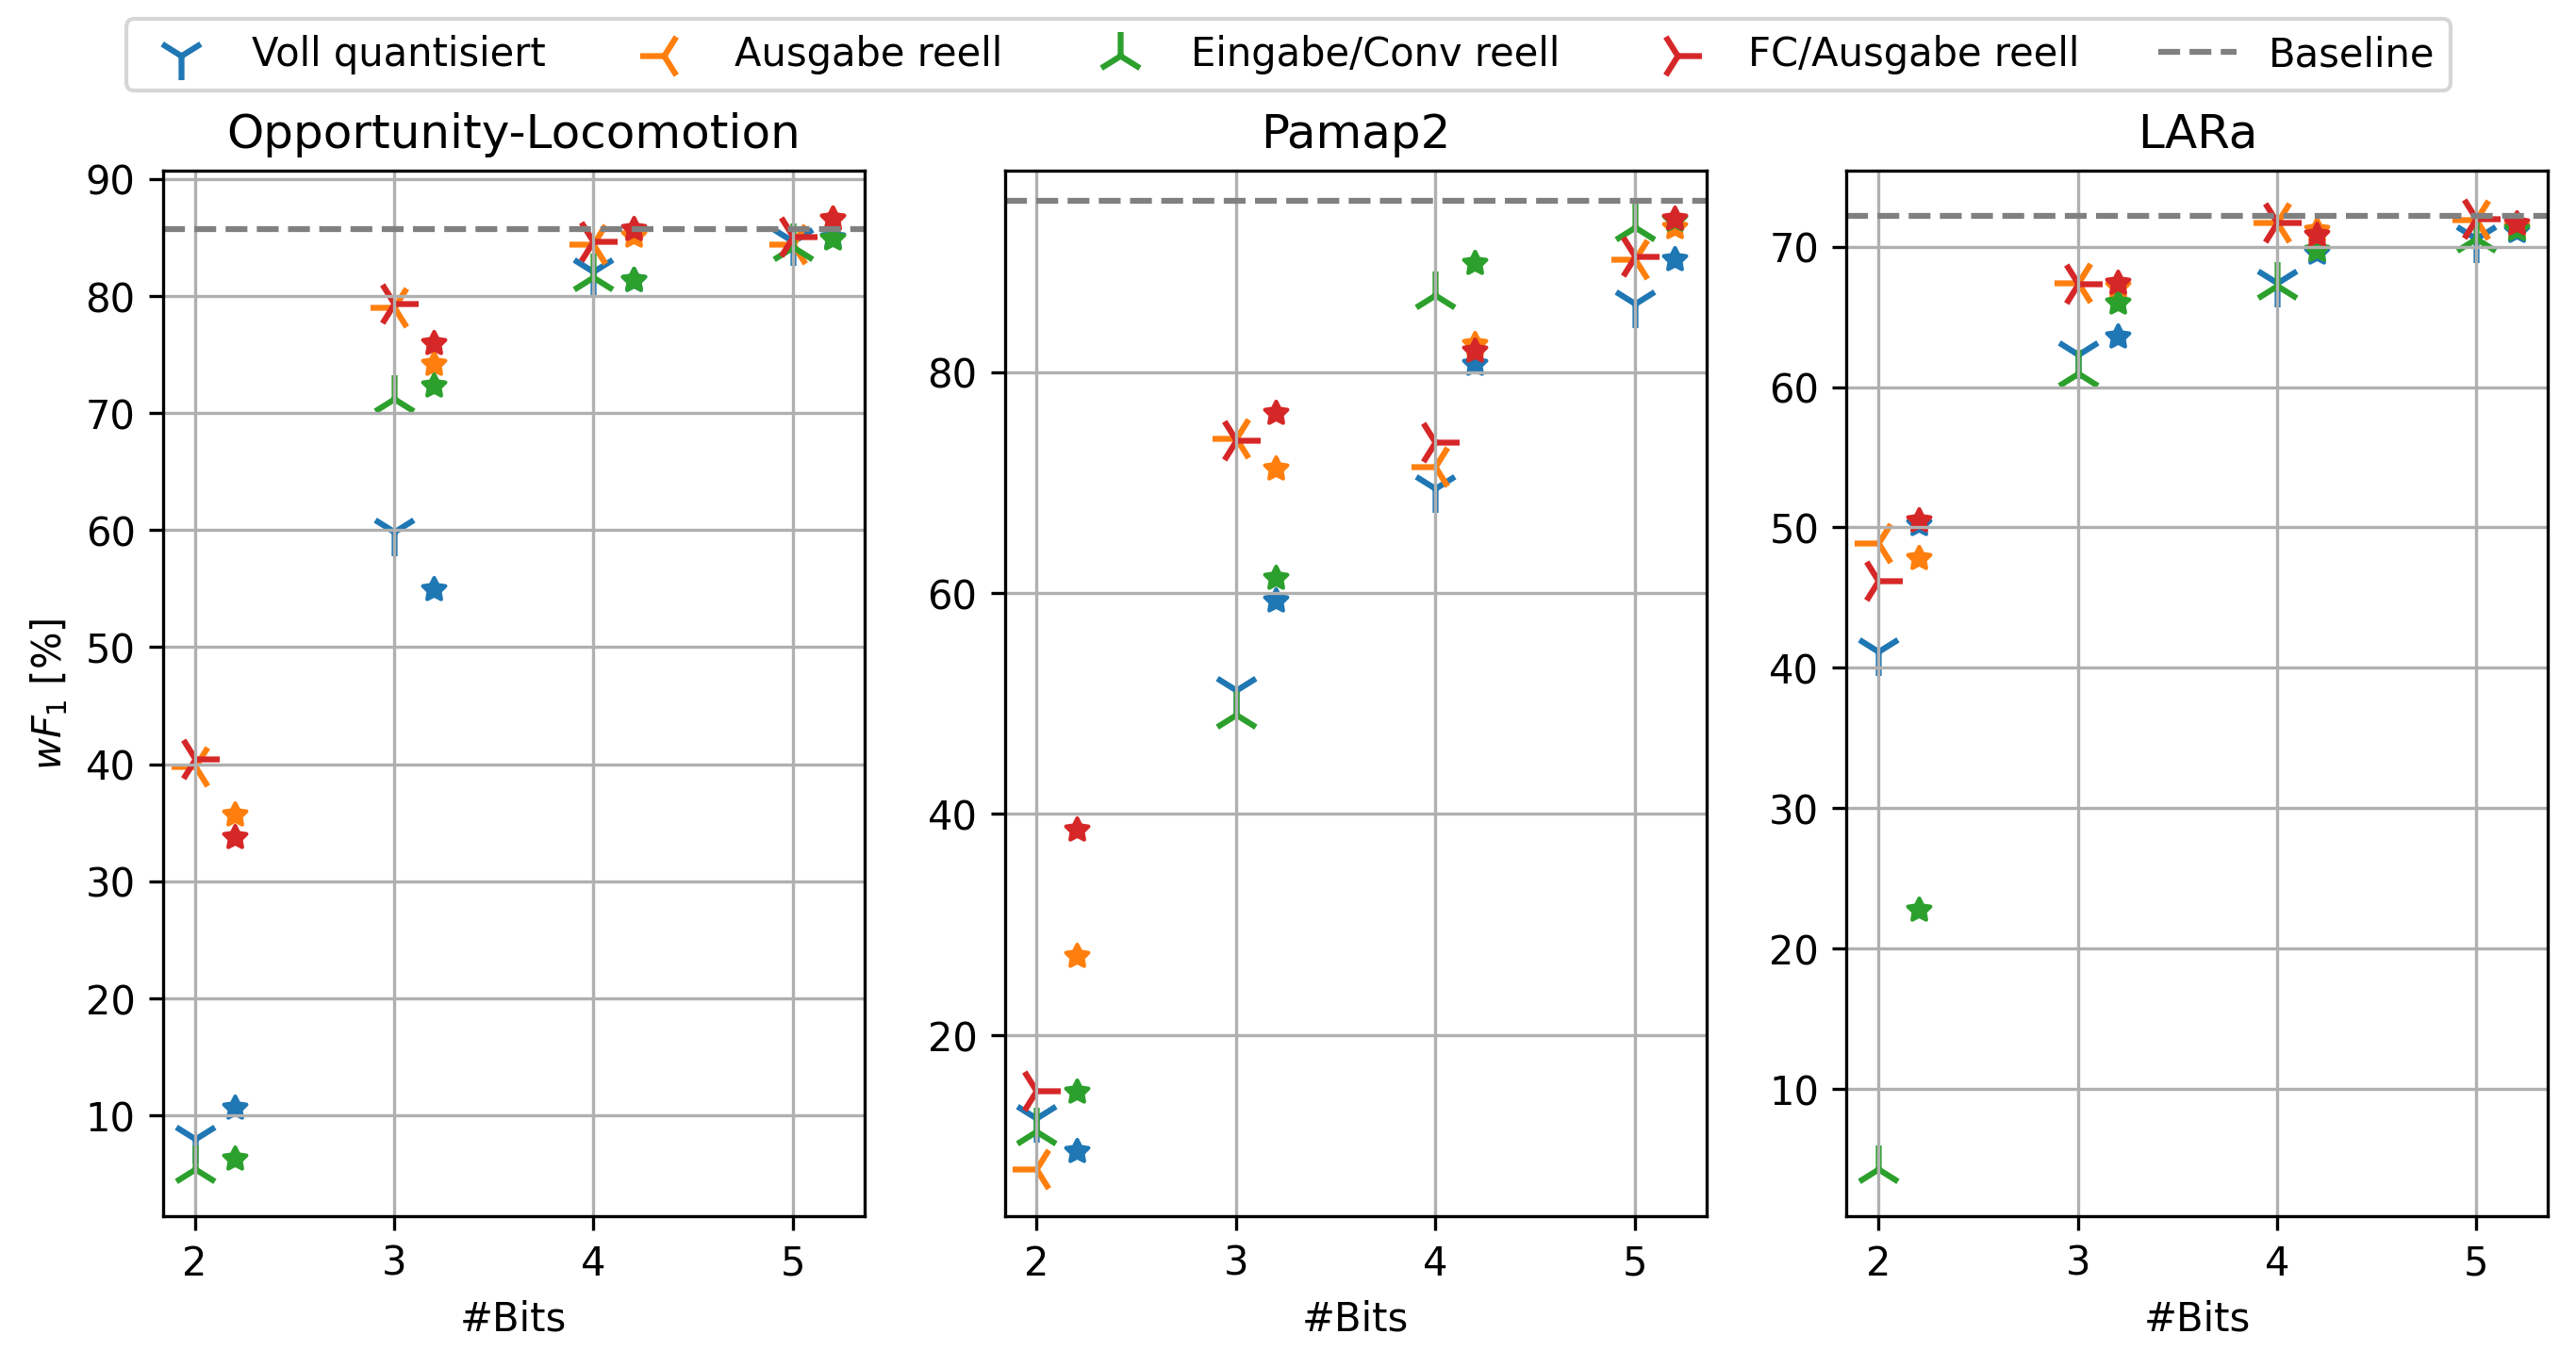

In [12]:

cfg_comparison_1_qat = {
    'Voll quantisiert': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'qat',
    },
    'Ausgabe reell': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'none',
    },
    'Eingabe/Ausgabe reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'none',
    },
}

cfg_comparison_1 = {
    'Voll quantisiert': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Ausgabe reell': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
    'Eingabe/Ausgabe reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
}

cfg_comparison_2_qat = {
    'Voll quantisiert': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'qat',
    },
    'Ausgabe reell': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'none',
    },
    'FC/Ausgabe reell': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'none',
        'output_layer_quantization': 'none',
    },
    'IMU-FC/FC/Ausgabe reell': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'none',
        'fc_quantization': 'none',
        'output_layer_quantization': 'none',
    },
}

cfg_comparison_3_qat = {
    'Voll quantisiert': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'qat',
    },
    'Ausgabe reell': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'none',
    },
    'Eingabe/Conv reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'none',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'qat',
    },
    'Eingabe/Conv/Ausgabe reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'none',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'none',
    },
}

cfg_comparison_4_qat = {
    'Voll quantisiert': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'qat',
    },
    'Ausgabe reell': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'none',
    },
    'Eingabe/Conv reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'none',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'qat',
        'output_layer_quantization': 'qat',
    },
    'FC/Ausgabe reell': {
        'imu_input_quantization': 'qat',
        'imu_pipeline_quantization': 'qat',
        'imu_pipeline_fc_quantization': 'qat',
        'fc_quantization': 'none',
        'output_layer_quantization': 'none',
    },
}

cfg_comparison_4 = {
    'Voll quantisiert': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Ausgabe reell': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
    'Eingabe/Conv reell': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'none',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'FC/Ausgabe reell': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'none',
        'output_layer_quantization': 'none',
    },
}

qat_variance_experiments = list(filter(lambda ex: ex.to_dict()['meta']['my_meta']['runner'] == 'qat_cnn_imu_run_bit_depth_modes.py', all_qat_experiments))
print(len(qat_variance_experiments))

cmap = cm.get_cmap('tab10')

for (cfg_comparison_qat, cfg_comparison) in ((cfg_comparison_1_qat, cfg_comparison_1), (cfg_comparison_2_qat,cfg_comparison_2), (cfg_comparison_3_qat,cfg_comparison_3), (cfg_comparison_4_qat,cfg_comparison_4)):
  ex_by_bits_by_cfg_by_dataset = defaultdict(lambda: defaultdict(dict))
  for key, cfg in cfg_comparison_qat.items():
    found = False
    for ex in qat_variance_experiments:
      cfg_subset = configSubset(ex, cfg.keys())
      if cfg_subset == cfg:
        bits = ex.to_dict()['config']['n_bits']
        dataset = ex.to_dict()['config']['use_dataset']
        d = ex_by_bits_by_cfg_by_dataset[dataset][key]
        if bits not in d:
          d[bits] = {'qat': [ex]}
        else:
          d[bits]['qat'].append(ex)
        found = True
    if not found:
      print(f'Not Found: {cfg}')

  for key, cfg in cfg_comparison.items():
    for ex in mode_vairance_experiments:
      cfg_subset = configSubset(ex, cfg.keys())
      if cfg_subset == cfg:
        bits = ex.to_dict()['config']['n_bits']
        dataset = ex.to_dict()['config']['use_dataset']
        d = ex_by_bits_by_cfg_by_dataset[dataset][key]
        if bits in d:
          d[bits]['ptq'] = ex

  ex_by_bits_by_cfg_by_dataset = {
      dataset: {
          key: dict(sorted(ex_by_bits.items(), key=lambda x: x[0], reverse=True))
          for key, ex_by_bits in ex_by_bits_by_cfg.items()
      } for dataset, ex_by_bits_by_cfg in ex_by_bits_by_cfg_by_dataset.items()
  }

  # Clasification performance plots
  fig, axs = plt.subplots(1, len(ex_by_bits_by_cfg_by_dataset))
  fig.set_dpi(300)
  fig.set_figwidth(fig.get_figwidth() * 1.7)
  handles, labels = [], []
  for ix, (dataset, ex_by_bits_by_cfg) in enumerate(ex_by_bits_by_cfg_by_dataset.items()):
    s_xs = []
    for k_ix, (key, ex_by_bits) in enumerate(ex_by_bits_by_cfg.items()):
      s_xs = np.array(list(ex_by_bits.keys()))
      def mwf1(exs):
        return np.array(list(map(lambda e: e.metrics['test/wf1'], exs))).mean()
      s_ys_qat = np.array([mwf1(e['qat']) for e in ex_by_bits.values()])
      s_ys_ptq = np.array([e['ptq'].metrics['test/wf1'] for e in ex_by_bits.values()])

      axs[ix].scatter(x=s_xs, y=s_ys_ptq * 100, label=key, color=cmap(k_ix), marker=markers[k_ix], s=150)
      #for sx, syq, syp in zip(s_xs, s_ys_qat*100, s_ys_ptq*100):
      #  axs[ix].plot([sx,sx+0.2], [syp, syq], color=cmap(k_ix))
      axs[ix].scatter(x=s_xs+0.2, y=s_ys_qat * 100, color=cmap(k_ix), marker=(5,1))

    baseline_wf1 = base_experiment_by_dataset[dataset].metrics['test/wf1'].max() * 100
    axs[ix].axhline(y=baseline_wf1, color='grey', linestyle='dashed', label='Baseline')
    axs[ix].set_xticks(s_xs)
    axs[ix].set_xticklabels(s_xs)
    axs[ix].set_xlabel('#Bits')
    if ix == 0:
        axs[ix].set_ylabel('$wF_1$ [%]')
    axs[ix].grid()
    axs[ix].set_title(friendly[dataset])
    handles, labels = axs[ix].get_legend_handles_labels()

  fig.legend(handles, labels, loc='upper center', ncol=6)
  fig.show()



In [41]:
best_models = {}
def exWF1(ex) -> float:
  return ex.metrics['test/wf1'].max()

e2e_7_cfg_subset = {
  'n_bits': 7,
  'activation_observer': 'torch.ao.quantization.MovingAverageMinMaxObserver',
  'weight_observer': 'torch.ao.quantization.PerChannelMinMaxObserver',
  'imu_input_quantization': 'static',
  'imu_pipeline_quantization': 'static',
  'imu_pipeline_fc_quantization': 'static',
  'fc_quantization': 'static',
  'output_layer_quantization': 'static'
}
out_5_cfg_subset = {
  'n_bits': 5,
  'imu_input_quantization': 'static',
  'imu_pipeline_quantization': 'static',
  'imu_pipeline_fc_quantization': 'static',
  'fc_quantization': 'static',
  'output_layer_quantization': 'none'
}
qco_3_cfg_subset = {
  'n_bits': 3,
  'imu_input_quantization': 'none',
  'imu_pipeline_quantization': 'none',
  'imu_pipeline_fc_quantization': 'qat',
  'fc_quantization': 'qat',
  'output_layer_quantization': 'none'
}
lara_cfg_subset = {
  'use_dataset': 'lara',
}
pamap2_cfg_subset = {
  'use_dataset': 'pamap2',
}
opportunity_cfg_subset = {
  'use_dataset': 'opportunity',
}

def predicate_subset(cfg_subset):
  return lambda ex: cfg_subset == configSubset(ex, cfg_subset.keys())

best_models = {
  'e2e_7' : list(filter(predicate_subset(e2e_7_cfg_subset), mode_vairance_experiments)),
  'out_5' : list(filter(predicate_subset(out_5_cfg_subset), mode_vairance_experiments)),
  'qco_3' : list(filter(predicate_subset(qco_3_cfg_subset), qat_variance_experiments)),
}

best_models = {
  k: {
    'opportunity': max(filter(predicate_subset(opportunity_cfg_subset), exs), key=exWF1),
    'pamap2': max(filter(predicate_subset(pamap2_cfg_subset), exs), key=exWF1),
    'lara': max(filter(predicate_subset(lara_cfg_subset), exs), key=exWF1),
  }
  for k, exs in best_models.items()
}
best_models['basel'] = base_experiment_by_dataset

logging.getLogger().setLevel(logging.CRITICAL)
def exInfo(ex) -> str:
  wf1 = ex.metrics['test/wf1'].max() * 100
  acc = ex.metrics['test/acc'].max() * 100
  times = ex.metrics['test/batch_time']  * 1000
  module_ckpts = checkpointsById(root='../logs/checkpoints', run_id=ex.to_dict()['_id'])
  memory = 0
  m = 0
  if 'best_wf1' in module_ckpts:
    m = CNNIMU.load_from_checkpoint(module_ckpts['best_wf1'])
    memory = estimateModuleSize(m, n_bits=0) 
  else:
    m = CNNIMU.load_from_checkpoint(module_ckpts['model'])
    memory = estimateModuleSize(m, n_bits=ex.to_dict()['config']['n_bits']) 
  del(m)
  tm = times.mean()
  ts = times.std()
  return f'{wf1=:0.2f} {acc=:0.2f} {tm=:0.2f} {ts=:0.2f} m={(memory/8)*1e-6:.02f}MB'

for k in best_models:
  print(k)
  for dataset, ex in best_models[k].items():
    print(f'  {dataset:<20} -> {exInfo(ex)}')
logging.getLogger().setLevel(logging.INFO)


e2e_7
  opportunity          -> wf1=85.68 acc=85.88 tm=100.79 ts=3.21 m=13.57MB
  pamap2               -> wf1=95.42 acc=95.13 tm=129.00 ts=7.05 m=29.81MB
  lara                 -> wf1=71.91 acc=73.00 tm=95.37 ts=0.58 m=22.93MB
out_5
  opportunity          -> wf1=84.39 acc=84.65 tm=101.15 ts=3.27 m=9.69MB
  pamap2               -> wf1=90.17 acc=89.32 tm=127.95 ts=2.20 m=21.31MB
  lara                 -> wf1=71.95 acc=73.01 tm=95.76 ts=0.56 m=16.39MB
qco_3


StopIteration: 